### Property Description impact on property churn

In [1]:
import platform
from datetime import date

import dtale
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyodbc
import scipy.stats
import seaborn as sns
import sweetviz
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine, text
from sqlalchemy.engine import URL

# import pandas_profiling


pd.set_option("display.max_columns", None)

In [2]:
import os

# Change the current working directory
os.chdir(
    "C:/Users/DeepankarSrigyan/OneDrive - Sykes Cottages Ltd/Desktop/Project/Property Description/"
)

In [3]:
def fetch_SQLserver_data(sql_code, conn_string):
    """
    Uses pyodbc.connect and pandas.read_sql to return query results as dataframe.
    :param sql_code: string, query to be submitted
    :param conn_string: string, full connection details as string
    """
    connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": conn_string})
    engine = create_engine(connection_url)
    with engine.connect() as conn:
        df = pd.read_sql(sql=text(sql_code), con=conn)
        conn.commit()
    print("Data Imported")
    return df


if platform.system() == "Windows":
    conn_CDM = "DRIVER={ODBC Driver 17 for SQL Server};SERVER=BI-DATA-PROD-04;DATABASE=CDM;trusted_connection=Yes"
    conn_l0 = "DRIVER={ODBC Driver 17 for SQL Server};SERVER=BI-DATA-PROD-04;DATABASE=Sykes_DW_Level0_Staging;trusted_connection=Yes"
    conn_l2 = "DRIVER={ODBC Driver 17 for SQL Server};SERVER=BI-DATA-PROD-04;DATABASE=Sykes_DW_Level2_ADM;trusted_connection=Yes"
    conn_BOX = "DRIVER={ODBC Driver 17 for SQL Server};SERVER=BI-DATA-PROD-04;DATABASE=Box;trusted_connection=Yes"

    print("Connection Completed")

Connection Completed


In [5]:
def convert_date_column(df, column_name):
    """
    Converts a date column in a DataFrame from string (object) to datetime.

    Args:
    df (pd.DataFrame): The DataFrame containing the date column.
    column_name (str): The name of the column to convert.

    Returns:
    pd.DataFrame: A DataFrame with the date column converted to datetime.
    """
    df[column_name] = pd.to_datetime(df[column_name], format="%Y-%m-%d")
    return df

### Property Description current table

In [4]:
raw_property_view = fetch_SQLserver_data(
    """
with property AS(
SELECT
    p.propertyid,
    p.propertyreference,
    p.propertylivedate,
    p.DateToldWithdrawingLocal,
    p.bedrooms,
    p.propertyType,
    p.sleeps,
    p.location,
    RANK() OVER (
        PARTITION BY p.propertyreference
        ORDER BY d.valid_to DESC
    ) AS property_rank,
    case when p.DateToldWithdrawingLocal is null then 0 else 1 end as churn,
    d.*
FROM
    CDM.propertymanagement.Property p
    LEFT JOIN
    [Sykes_DW_Level0_Staging].[YMIR_toms].[property_description] d
    ON p.PropertyReference = d._fk_property
WHERE 
    --p.propertylivedate >= '2020-01-01'
    --AND 
    p.PropertyLiveDate IS NOT NULL
    AND d.valid_from IS NOT NULL
    AND (
        p.PropertyLiveDate >= d.valid_from
    AND p.PropertyLiveDate <= COALESCE(d.valid_to, CAST(GETDATE() AS DATE))
    )
    
-- ORDER BY 
--     p.PropertyReference
)
select * from property where property_rank=1


""",
    conn_CDM,
)
raw_property_view

Data Imported


,propertyid,propertyreference,propertylivedate,DateToldWithdrawingLocal,bedrooms,propertyType,sleeps,location,property_rank,churn,__pk,_fk_property,valid_from,valid_to,property_characteristics_building,property_characteristics_location,property_characteristics_policy,property_characteristics_entertainment,property_characteristics_landing_page,property_characteristics_facilities,details_general,details_accomodation,details_amenities,short_description,language,purpose,details_directions,wd_general_details,wd_accom_details,wd_ammenities_details,brochure_description,bd_general_details,bd_accom_details,bd_ammenities_details,tpd_region_description,tpd_town_description,tpd_home_summary,tpd_home_description,tpd_cottage_name_30,tpd_cottage_name_100,tpd_lte_home_summary,tpd_exterior_facilities,tpd_interior_facilities,tpd_rental_details,tpd_special_conditions,rd_gen_keywords,rd_gen_property_description,rd_gen_general,rd_inside_floor_title,rd_inside_floor,rd_inside_floor_title_2,rd_inside_floor_2,rd_inside_floor_title_3,rd_inside_floor_3,rd_inside_floor_title_4,rd_inside_floor_4,rd_inside_floor_title_5,rd_inside_floor_5,rd_inside_floor_title_6,rd_inside_floor_6,rd_inside_floor_title_7,rd_inside_floor_7,rd_outside,rd_notes,rd_area_drivingtimes,rd_area_nearestshop,rd_area_nearestpub,rd_area_nearestvillage,rd_area_nearesttown,rd_area_nearestbeach,rd_area_doorstep,rd_area_daytrip,rd_descriptionlive,rd_descriptionbrand,time_createdutc,wd_general_details_html,wd_accom_details_html,wd_ammenities_details_html,tripadvisor_village,tripadvisor_subregion,tripadvisor_region,tripadvisor_country,tripadvisor_title,short_description_intro,short_description_full,short_description_proofread,short_description_proofread_user,medium_description_intro,medium_description_full,medium_description_proofread,medium_description_proofread_user,long_description_intro,long_description_full,long_description_proofread,long_description_proofread_user,acquisition_short_description,acquisition_long_description,access_statement,strapline,last_updatedutc
0,52170,567,2014-09-30,None,2.0,Semi detached,4.0,Carperby,1,0,38511,567.0,2013-11-12,2033-11-12,None,None,None,None,Landing Page - Near Walks\rLanding Page - Gay/...,,"An attractive, semi-detached, stone-built cott...",Two bedrooms: 1 x master bedroom with king-siz...,"Heating from night storage heaters, electric p...",Delightful stone-built converted barn in quiet...,None,Filemaker Import,Leave the A1 at Bedale (A684). \r\rFollow the...,"Located in the Yorkshire Dales National Park, ...",Two bedrooms: 1 x master bedroom with king-siz...,"Heating from night storage heaters, electric p...",None,None,None,None,"From heather-clad moors and limestone scars, t...",Situated close to well-known Aysgarth Falls an...,This stone built semi detached cottage is situ...,"Barnbrook is a semi detached, stone built deta...",Barnbrook,"Barnbrook, Yorkshire Dales",This stone built semi detached cottage is situ...,,,,,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,,None,,,,,,,None,None,No,None,2013-11-12 05:05:27,"An attractive, semi-detached, stone-built cott...",Two bedrooms: 1 x master bedroom with king-siz...,"Heating from night storage heaters, electric p...",Carperby,North Yorkshire,Yorkshire Dales,England,"BARNBROOK, family friendly, character holiday ...","A delightful, stone-built barn conversion on t...",Very well-equipped and with a wonderfully cosy...,1,sheryl.latham,"A delightful, stone-built barn conversion in a...",Very well-equipped and with a wonderfully cosy...,1,sheryl.latham,,,0,None,None,None,None,None,2021-09-23 07:16:26
1,53728,623,2014-07-14,2014-07-14,1.0,Flat,2.0,Embleton,1,1,38525,623.0,2013-11-12,2033-11-12,None,None,None,None,Landing Page - Seaside\rLanding Page - Beach\r...,,"A cosy, stone-built holiday property tucked aw...",One double bedroom. Shower room with shower cu...,"Electric storage heaters. Electric cooker, mic...",Cosy and well-equipped stone-built cottage tuc...,None,F

In [13]:
# # raw_property = convert_date_column(raw_property, 'PropertyLiveDate')
# raw_property = convert_date_column(raw_property, 'valid_from')
# # raw_property = convert_date_column(raw_property, 'valid_to')
# # raw_property = convert_date_column(raw_property, 'DateToldWithdrawingLocal')
# # raw_property = convert_date_column(raw_property, 'last_updatedutc')

In [5]:
raw_property_view.to_excel('raw_property_view_alltime.xlsx')

In [17]:
PropertyDescReport_Raw = sweetviz.analyze(raw_property_view)
PropertyDescReport_Raw.show_html("raw_property_view.html")

                                             |                                                                …

C:\Users\DeepankarSrigyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sweetviz\graph.py:33: UserWarning:

Glyph 9 (	) missing from current font.

C:\Users\DeepankarSrigyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sweetviz\graph.py:33: UserWarning:

Glyph 9 (	) missing from current font.

C:\Users\DeepankarSrigyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sweetviz\graph.py:33: UserWarning:

Glyph 9 (	) missing from current font.



Report raw_property_view.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [7]:
def add_length_columns(df):
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df_copy = df.copy()
    
    for col in df_copy.columns:
        # Create new column name
        new_col_name = f'Len_{col}'
        # Calculate lengths of each value in the column using loc
        df_copy.loc[:, new_col_name] = df_copy[col].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
    
    return df_copy




In [8]:
subset_property = raw_property_view[
    [
        "propertyid",
        "propertyreference",
        "propertylivedate",
        "DateToldWithdrawingLocal",
        "bedrooms",
        "propertyType",
        "sleeps",
        "location",
        "churn",
        "valid_from",
        "valid_to",
        "short_description",
        "wd_general_details",
        "wd_accom_details",
        "wd_ammenities_details",
        "acquisition_short_description",
        "acquisition_long_description"        
    ]
]
# subset_property

property_withstringsize = add_length_columns(subset_property)
property_withstringsize

,propertyid,propertyreference,propertylivedate,DateToldWithdrawingLocal,bedrooms,propertyType,sleeps,location,churn,valid_from,valid_to,short_description,wd_general_details,wd_accom_details,wd_ammenities_details,acquisition_short_description,acquisition_long_description,Len_propertyid,Len_propertyreference,Len_propertylivedate,Len_DateToldWithdrawingLocal,Len_bedrooms,Len_propertyType,Len_sleeps,Len_location,Len_churn,Len_valid_from,Len_valid_to,Len_short_description,Len_wd_general_details,Len_wd_accom_details,Len_wd_ammenities_details,Len_acquisition_short_description,Len_acquisition_long_description
0,127056,917853,2020-02-26,2023-01-25,3,House semi-detached,6.0,Craig-y-penrhyn,1,2016-09-13,None,A welcoming base from which to discover the co...,Boasting a beautiful blue exterior and an equa...,"Three bedrooms: 1 x king-size, 1 x double and ...",Oil central heating and woodburning stove. Gas...,None,None,6,6,10,10,1,19,3,15,1,10,0,188,4017,257,444,0,0
1,277826,917931,2024-04-24,None,2,House detached,4.0,Abererch,0,2016-09-13,None,"The Mill is a welcoming, single-storey, barn c...","The Mill, nestled amidst the picturesque lands...","Single-storey. Two bedrooms: 1 x double, 1 x t...","Oil central heating. Electric oven and hob, mi...","The Mill is a welcoming, single-storey, barn c...",Pwllheli 2.7 miles.,6,6,10,0,1,14,3,8,1,10,0,193,2128,185,551,193,19
2,50037,2074,2023-05-09,None,3,Terraced,5.0,Pentre Hodre,0,2013-11-12,2033-11-12,Superb Grade II listed barn conversion 2 miles...,A stunning barn conversion on the outskirts of...,Three bedrooms: 1 x double with en-suite showe...,"Electric oven & hob, microwave, fridge/freezer...",None,None,5,4,10,0,1,8,3,12,1,10,10,135,242,236,690,0,0
3,71687,918526,2021-11-01,None,3,Semi detached,6.0,St Lawrence,0,2016-03-08,2033-03-08,"This lovely three bed semi-detached bungalow, ...",Swifts is the larger of the two semi-detached ...,All ground floor: Three bedrooms: 1 x double w...,"Electric panel heaters. Electric oven and hob,...",None,None,5,6,10,0,1,13,3,11,1,10,10,188,676,191,682,0,0
4,51456,3888,2024-03-19,None,2,House detached,5.0,Moneystone,0,2013-11-12,2033-11-12,"This delightful, two-bedroom cottage is based ...",Oakamoor 1 mile. Barks Cottage is nestled in t...,"Single-storey. Two bedrooms: 1 x double, 1 x f...","LPG central heating. Electric oven and hob, mi...",None,None,5,4,10,0,1,14,3,10,1,10,10,198,2990,181,863,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18801,284871,1156524,2024-06-05,None,2,Cottage,4.0,Royal Oak,0,2024-05-28,None,Ivy is a ground-floor cottage situated in the ...,Set near the Yorkshire coast and within a col...,"Single-storey. Two Bedrooms: 1x double, 1 x tw...","Oil central heating. Electric oven and hob, m...",This is a ground-floor cottage situated in the...,Enjoying a great position near the Yorkshire c...,6,7,10,0,1,7,3,9,1,10,0,200,1307,184,766,201,1344
18802,284836,1156525,2024-06-05,None,2,Cottage,4.0,Royal Oak,0,2024-05-28,None,Primrose is a superb stone cottage rests in Hu...,Primrose is a delightful stone cottage nestled...,Two bedrooms: 1 x double and 1 x twin. Bathroo...,Oil central heating with electric fire. Electr...,"This superb stone cottage rests in Hunmanby, N...",Primrose is a delightful stone cottage nestled...,6,7,10,0,1,7,3,9,1,10,0,214,1028,140,614,107,1005
18803,284837,1156526,2024-06-05,None,2,Cottage,4.0,Royal Oak,0,2024-05-28,None,"Willow is a lovely, semi-detached holiday cott...","Willow is a lovely semi-detached cottage, 1 of...",Two bedrooms: 1 x double and 1 x twin. Upstair...,Oil central heating with on/off switch. Electr...,None,None,6,7,10,0,1,7,3,9,1,10,0,208,1059,154,786,0,0
18804,284872,1156527,2024-06-05,None,2,Cottage,4.0,Royal Oak,0,2024-05-28,None,"Rose is a charming, quaint cottage in Hunmanby...",Rose is settled amidst delightful neighbouring...,"Two bedrooms: 1 x double, 1 x twin. Bathroom w...",Oil central hea

In [29]:
property_withstringsize.to_excel('property_withstringsize.xlsx')

### Correlation

In [9]:
numerical_property_withstringsize = property_withstringsize.select_dtypes(include=['number'])

# Calculate the correlation matrix for numerical columns
correlation_matrix = numerical_property_withstringsize.corr()
correlation_matrix

,propertyid,propertyreference,bedrooms,sleeps,churn,Len_propertyid,Len_propertyreference,Len_propertylivedate,Len_DateToldWithdrawingLocal,Len_bedrooms,Len_propertyType,Len_sleeps,Len_location,Len_churn,Len_valid_from,Len_valid_to,Len_short_description,Len_wd_general_details,Len_wd_accom_details,Len_wd_ammenities_details,Len_acquisition_short_description,Len_acquisition_long_description
propertyid,1.000000,0.527508,-0.032958,-0.021694,-0.268038,0.124183,0.128393,NaN,-0.268038,0.007278,-0.026858,-0.017534,-0.009427,NaN,NaN,-0.117047,0.167411,-0.327373,-0.022957,-0.004776,0.059539,0.020444
propertyreference,0.527508,1.000000,-0.037685,-0.027415,-0.109143,0.288235,0.692897,NaN,-0.109143,-0.006130,-0.018759,-0.020407,-0.006899,NaN,NaN,-0.297523,0.086735,-0.176253,-0.031016,-0.011558,0.064332,0.056926
bedrooms,-0.032958,-0.037685,1.000000,0.946652,-0.018254,0.001346,-0.022985,NaN,-0.018254,0.419973,0.097654,0.653827,0.016277,NaN,NaN,-0.004132,0.038193,0.272727,0.673153,0.185489,0.037993,0.093445
sleeps,-0.021694,-0.027415,0.946652,1.000000,-0.021465,0.002996,-0.018158,NaN,-0.021465,0.447575,0.092328,0.686816,0.012678,NaN,NaN,-0.005236,0.039140,0.249966,0.684092,0.188496,0.032175,0.084082
churn,-0.268038,-0.109143,-0.018254,-0.021465,1.000000,0.037462,0.011807,NaN,1.000000,-0.017973,-0.007099,-0.012335,0.017747,NaN,NaN,-0.034554,-0.090756,0.063245,-0.069236,-0.108348,-0.092048,-0.152412
Len_propertyid,0.124183,0.288235,0.001346,0.002996,0.037462,1.000000,0.324780,NaN,0.037462,0.003188,-0.003321,0.004358,0.001263,NaN,NaN,-0.899242,0.028355,0.051899,-0.016286,-0.007436,0.009301,0.019652
Len_propertyreference,0.128393,0.692897,-0.022985,-0.018158,0.011807,0.324780,1.000000,NaN,0.011807,-0.008369,-0.005580,-0.015154,-0.000207,NaN,NaN,-0.315076,0.015092,-0.028449,-0.022803,-0.024141,0.049417,0.065354
Len_propertylivedate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Len_DateToldWithdrawingLocal,-0.268038,-0.109143,-0.018254,-0.021465,1.000000,0.037462,0.011807,NaN,1.000000,-0.017973,-0.007099,-0.012335,0.017747,NaN,NaN,-0.034554,-0.090756,0.063245,-0.069236,-0.108348,-0.092048,-0.152412
Len_bedrooms,0.007278,-0.006130,0.419973,0.447575,-0.017973,0.003188,-0.008369,NaN,-0.017973,1.000000,0.037233,0.239347,0.004729,NaN,NaN,-0.002941,0.023361,0.064137,0.310489,0.086837,-0.010162,-0.002345


In [44]:
# correlation_matrix

                               Column  Correlation with Churn
0                          propertyid               -0.268038
1                   propertyreference               -0.109143
2                            bedrooms               -0.018254
3                              sleeps               -0.021465
4                      Len_propertyid                0.037462
5               Len_propertyreference                0.011807
6                Len_propertylivedate                     NaN
7        Len_DateToldWithdrawingLocal                1.000000
8                        Len_bedrooms               -0.017973
9                    Len_propertyType               -0.007099
10                         Len_sleeps               -0.012335
11                       Len_location                0.017747
12                          Len_churn                     NaN
13                     Len_valid_from                     NaN
14                       Len_valid_to               -0.034554
15      

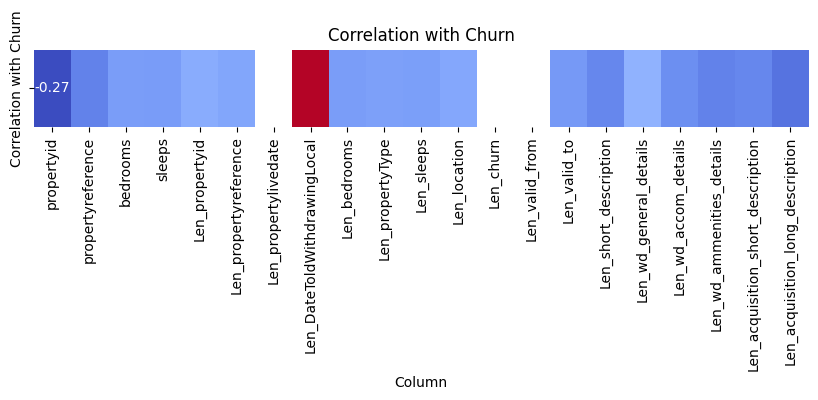

In [11]:
numerical_df = numerical_property_withstringsize.select_dtypes(include=['number'])

# Calculate the correlation of each numerical column with 'Churn'
correlation_with_churn = numerical_df.corr()['churn'].drop('churn')

# Convert the correlation series to a DataFrame for better visualization
correlation_df = correlation_with_churn.to_frame().reset_index()
correlation_df.columns = ['Column', 'Correlation with Churn']

# Print the correlation values
print(correlation_df)

# Create a heatmap of the correlation with 'Churn'
plt.figure(figsize=(10, 1))
sns.heatmap(correlation_df.set_index('Column').T, annot=True, cmap='coolwarm', cbar=False)
plt.title('Correlation with Churn')
plt.show()

In [28]:
# correlation_df.to_excel('correlation_df.xlsx')

### Complexity check

In [12]:
import textstat

def add_readability_scores(df):
    # Select only string columns
    string_cols = df.select_dtypes(include=['object']).columns
    
    for col in string_cols:
        # Create new column names for readability metrics
        flesch_col = f'Flesch_{col}'
        fk_grade_col = f'FK_Grade_{col}'
        
        # Calculate readability metrics
        df[flesch_col] = df[col].apply(lambda x: textstat.flesch_reading_ease(x) if pd.notna(x) and isinstance(x, str) else None)
        df[fk_grade_col] = df[col].apply(lambda x: textstat.flesch_kincaid_grade(x) if pd.notna(x) and isinstance(x, str) else None)
    
    return df


In [14]:
df_readability=add_readability_scores(property_withstringsize)
df_readability

,propertyid,propertyreference,propertylivedate,DateToldWithdrawingLocal,bedrooms,propertyType,sleeps,location,churn,valid_from,valid_to,short_description,wd_general_details,wd_accom_details,wd_ammenities_details,acquisition_short_description,acquisition_long_description,Len_propertyid,Len_propertyreference,Len_propertylivedate,Len_DateToldWithdrawingLocal,Len_bedrooms,Len_propertyType,Len_sleeps,Len_location,Len_churn,Len_valid_from,Len_valid_to,Len_short_description,Len_wd_general_details,Len_wd_accom_details,Len_wd_ammenities_details,Len_acquisition_short_description,Len_acquisition_long_description,Flesch_propertylivedate,FK_Grade_propertylivedate,Flesch_DateToldWithdrawingLocal,FK_Grade_DateToldWithdrawingLocal,Flesch_propertyType,FK_Grade_propertyType,Flesch_location,FK_Grade_location,Flesch_valid_from,FK_Grade_valid_from,Flesch_valid_to,FK_Grade_valid_to,Flesch_short_description,FK_Grade_short_description,Flesch_wd_general_details,FK_Grade_wd_general_details,Flesch_wd_accom_details,FK_Grade_wd_accom_details,Flesch_wd_ammenities_details,FK_Grade_wd_ammenities_details,Flesch_acquisition_short_description,FK_Grade_acquisition_short_description,Flesch_acquisition_long_description,FK_Grade_acquisition_long_description
0,127056,917853,2020-02-26,2023-01-25,3,House semi-detached,6.0,Craig-y-penrhyn,1,2016-09-13,None,A welcoming base from which to discover the co...,Boasting a beautiful blue exterior and an equa...,"Three bedrooms: 1 x king-size, 1 x double and ...",Oil central heating and woodburning stove. Gas...,None,None,6,6,10,10,1,19,3,15,1,10,0,188,4017,257,444,0,0,None,None,None,None,77.91,2.9,36.62,8.4,None,None,None,None,72.32,5.0,57.64,12.7,69.79,6.0,79.97,4.2,NaN,NaN,NaN,NaN
1,277826,917931,2024-04-24,None,2,House detached,4.0,Abererch,0,2016-09-13,None,"The Mill is a welcoming, single-storey, barn c...","The Mill, nestled amidst the picturesque lands...","Single-storey. Two bedrooms: 1 x double, 1 x t...","Oil central heating. Electric oven and hob, mi...","The Mill is a welcoming, single-storey, barn c...",Pwllheli 2.7 miles.,6,6,10,0,1,14,3,8,1,10,0,193,2128,185,551,193,19,None,None,None,None,77.91,2.9,36.62,8.4,None,None,None,None,57.27,8.8,56.49,11.1,78.25,4.8,80.99,3.8,57.27,8.8,59.97,5.6
2,50037,2074,2023-05-09,None,3,Terraced,5.0,Pentre Hodre,0,2013-11-12,2033-11-12,Superb Grade II listed barn conversion 2 miles...,A stunning barn conversion on the outskirts of...,Three bedrooms: 1 x double with en-suite showe...,"Electric oven & hob, microwave, fridge/freezer...",None,None,5,4,10,0,1,8,3,12,1,10,10,135,242,236,690,0,0,None,None,None,None,36.62,8.4,35.61,8.8,None,None,None,None,72.83,4.8,42.38,10.3,75.20,6.0,70.90,5.6,NaN,NaN,NaN,NaN
3,71687,918526,2021-11-01,None,3,Semi detached,6.0,St Lawrence,0,2016-03-08,2033-03-08,"This lovely three bed semi-detached bungalow, ...",Swifts is the larger of the two semi-detached ...,All ground floor: Three bedrooms: 1 x double w...,"Electric panel heaters. Electric oven and hob,...",None,None,5,6,10,0,1,13,3,11,1,10,10,188,676,191,682,0,0,None,None,None,None,35.61,8.8,120.21,-3.1,None,None,None,None,70.50,5.7,65.46,9.7,93.85,3.0,80.68,3.9,NaN,NaN,NaN,NaN
4,51456,3888,2024-03-19,None,2,House detached,5.0,Moneystone,0,2013-11-12,2033-11-12,"This delightful, two-bedroom cottage is based ...",Oakamoor 1 mile. Barks Cottage is nestled in t...,"Single-storey. Two bedrooms: 1 x double, 1 x f...","LPG central heating. Electric oven and hob, mi...",None,None,5,4,10,0,1,14,3,10,1,10,10,198,2990,181,863,0,0,None,None,None,None,77.91,2.9,-47.99,20.2,None,None,None,None,62.64,6.7,43.56,14.0,78.55,4.7,71.10,5.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18801,284871,1156524,2024-06-05,None,2,Cottage,4.0,Royal Oak,0,2024-05-28,None,Ivy is a ground-floor cottage situated in the ...,S

In [15]:
df_readability.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18806 entries, 0 to 18805
Data columns (total 58 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   propertyid                              18806 non-null  int64  
 1   propertyreference                       18806 non-null  int64  
 2   propertylivedate                        18806 non-null  object 
 3   DateToldWithdrawingLocal                6752 non-null   object 
 4   bedrooms                                18806 non-null  int64  
 5   propertyType                            18806 non-null  object 
 6   sleeps                                  18803 non-null  float64
 7   location                                18804 non-null  object 
 8   churn                                   18806 non-null  int64  
 9   valid_from                              18806 non-null  object 
 10  valid_to                                40 non-null     ob

In [16]:
description_Final=df_readability[[
"propertyid",
"propertyreference",
"propertylivedate",
"DateToldWithdrawingLocal",
"bedrooms",
"propertyType",
"sleeps",
"location",
"churn",
"valid_from",
"valid_to",
"short_description",
"wd_general_details",
"wd_accom_details",
"wd_ammenities_details",
"acquisition_short_description",
"acquisition_long_description",
"Len_short_description",
"Len_wd_general_details",
"Len_wd_accom_details",
"Len_wd_ammenities_details",
"Len_acquisition_short_description",
"Len_acquisition_long_description",
"Flesch_short_description",
"FK_Grade_short_description",
"Flesch_wd_general_details",
"FK_Grade_wd_general_details",
"Flesch_wd_accom_details",
"FK_Grade_wd_accom_details",
"Flesch_wd_ammenities_details",
"FK_Grade_wd_ammenities_details",
"Flesch_acquisition_short_description",
"FK_Grade_acquisition_short_description",
"Flesch_acquisition_long_description",
"FK_Grade_acquisition_long_description"    
]]
description_Final

,propertyid,propertyreference,propertylivedate,DateToldWithdrawingLocal,bedrooms,propertyType,sleeps,location,churn,valid_from,valid_to,short_description,wd_general_details,wd_accom_details,wd_ammenities_details,acquisition_short_description,acquisition_long_description,Len_short_description,Len_wd_general_details,Len_wd_accom_details,Len_wd_ammenities_details,Len_acquisition_short_description,Len_acquisition_long_description,Flesch_short_description,FK_Grade_short_description,Flesch_wd_general_details,FK_Grade_wd_general_details,Flesch_wd_accom_details,FK_Grade_wd_accom_details,Flesch_wd_ammenities_details,FK_Grade_wd_ammenities_details,Flesch_acquisition_short_description,FK_Grade_acquisition_short_description,Flesch_acquisition_long_description,FK_Grade_acquisition_long_description
0,127056,917853,2020-02-26,2023-01-25,3,House semi-detached,6.0,Craig-y-penrhyn,1,2016-09-13,None,A welcoming base from which to discover the co...,Boasting a beautiful blue exterior and an equa...,"Three bedrooms: 1 x king-size, 1 x double and ...",Oil central heating and woodburning stove. Gas...,None,None,188,4017,257,444,0,0,72.32,5.0,57.64,12.7,69.79,6.0,79.97,4.2,NaN,NaN,NaN,NaN
1,277826,917931,2024-04-24,None,2,House detached,4.0,Abererch,0,2016-09-13,None,"The Mill is a welcoming, single-storey, barn c...","The Mill, nestled amidst the picturesque lands...","Single-storey. Two bedrooms: 1 x double, 1 x t...","Oil central heating. Electric oven and hob, mi...","The Mill is a welcoming, single-storey, barn c...",Pwllheli 2.7 miles.,193,2128,185,551,193,19,57.27,8.8,56.49,11.1,78.25,4.8,80.99,3.8,57.27,8.8,59.97,5.6
2,50037,2074,2023-05-09,None,3,Terraced,5.0,Pentre Hodre,0,2013-11-12,2033-11-12,Superb Grade II listed barn conversion 2 miles...,A stunning barn conversion on the outskirts of...,Three bedrooms: 1 x double with en-suite showe...,"Electric oven & hob, microwave, fridge/freezer...",None,None,135,242,236,690,0,0,72.83,4.8,42.38,10.3,75.20,6.0,70.90,5.6,NaN,NaN,NaN,NaN
3,71687,918526,2021-11-01,None,3,Semi detached,6.0,St Lawrence,0,2016-03-08,2033-03-08,"This lovely three bed semi-detached bungalow, ...",Swifts is the larger of the two semi-detached ...,All ground floor: Three bedrooms: 1 x double w...,"Electric panel heaters. Electric oven and hob,...",None,None,188,676,191,682,0,0,70.50,5.7,65.46,9.7,93.85,3.0,80.68,3.9,NaN,NaN,NaN,NaN
4,51456,3888,2024-03-19,None,2,House detached,5.0,Moneystone,0,2013-11-12,2033-11-12,"This delightful, two-bedroom cottage is based ...",Oakamoor 1 mile. Barks Cottage is nestled in t...,"Single-storey. Two bedrooms: 1 x double, 1 x f...","LPG central heating. Electric oven and hob, mi...",None,None,198,2990,181,863,0,0,62.64,6.7,43.56,14.0,78.55,4.7,71.10,5.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18801,284871,1156524,2024-06-05,None,2,Cottage,4.0,Royal Oak,0,2024-05-28,None,Ivy is a ground-floor cottage situated in the ...,Set near the Yorkshire coast and within a col...,"Single-storey. Two Bedrooms: 1x double, 1 x tw...","Oil central heating. Electric oven and hob, m...",This is a ground-floor cottage situated in the...,Enjoying a great position near the Yorkshire c...,200,1307,184,766,201,1344,71.82,5.2,51.62,13.0,78.55,4.7,80.48,4.0,71.82,5.2,62.21,11.0
18802,284836,1156525,2024-06-05,None,2,Cottage,4.0,Royal Oak,0,2024-05-28,None,Primrose is a superb stone cottage rests in Hu...,Primrose is a delightful stone cottage nestled...,Two bedrooms: 1 x double and 1 x twin. Bathroo...,Oil central heating with electric fire. Electr...,"This superb stone cottage rests in Hunmanby, N...",Primrose is a delightful stone cottage nestled...,214,1028,140,614,107,1005,72.02,5.2,55.27,11.6,88.43,3.0,79.97,4.2,56.25,9.1,58.62,10.3
18803,284837,1156526,2024-06-05,None,2,Cottage,4.0,Royal Oak,0,2024-05-28,None,"Willow is a lovely, semi-detached holiday cott...","Willow is a lovely semi-detache

In [17]:
description_Final.to_excel("description_Final.xlsx")

                                    Column  Correlation with Churn
0                               propertyid               -0.268038
1                        propertyreference               -0.109143
2                                 bedrooms               -0.018254
3                                   sleeps               -0.021465
4                    Len_short_description               -0.090756
5                   Len_wd_general_details                0.063245
6                     Len_wd_accom_details               -0.069236
7                Len_wd_ammenities_details               -0.108348
8        Len_acquisition_short_description               -0.092048
9         Len_acquisition_long_description               -0.152412
10                Flesch_short_description                0.029461
11              FK_Grade_short_description               -0.035289
12               Flesch_wd_general_details               -0.032429
13             FK_Grade_wd_general_details                0.06

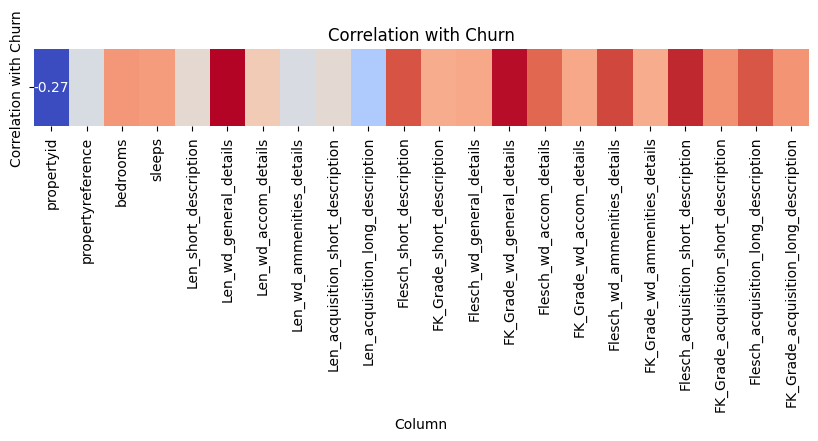

In [17]:
numerical_df = description_Final.select_dtypes(include=['number'])

# Calculate the correlation of each numerical column with 'Churn'
correlation_with_churn = numerical_df.corr()['churn'].drop('churn')

# Convert the correlation series to a DataFrame for better visualization
correlation_df = correlation_with_churn.to_frame().reset_index()
correlation_df.columns = ['Column', 'Correlation with Churn']

# Print the correlation values
print(correlation_df)

# Create a heatmap of the correlation with 'Churn'
plt.figure(figsize=(10, 1))
sns.heatmap(correlation_df.set_index('Column').T, annot=True, cmap='coolwarm', cbar=False)
plt.title('Correlation with Churn')
plt.show()

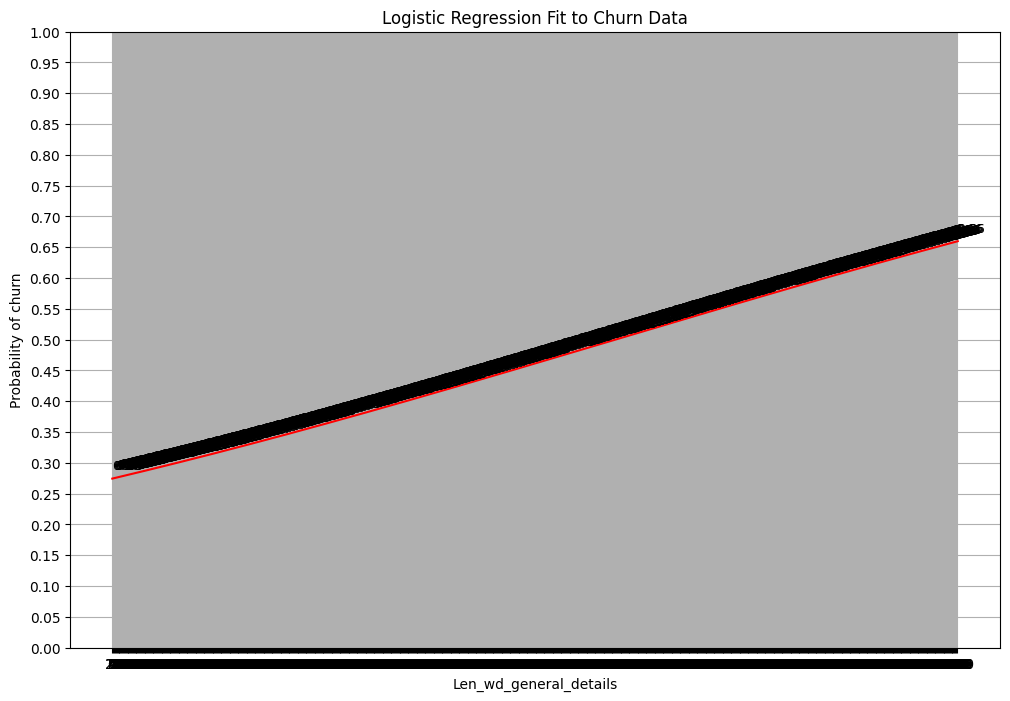

In [47]:
def log_reg_graph(df, independent, dependent):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.linear_model import LogisticRegression
    import numpy as np

    # Reshape data for sklearn
    X = df[independent].values.reshape(-1, 1)
    y = df[dependent].values

    # Fit logistic regression model
    model = LogisticRegression()
    model.fit(X, y)  # Use X and y arrays here, not the column names

    # Generate predictions for a smooth curve
    X_test = np.arange(df[independent].min(), df[independent].max() + 1).reshape(-1, 1)
    y_pred = model.predict_proba(X_test)[:, 1]

    # Plotting the logistic regression result
    plt.figure(figsize=(12, 8))
    # sns.scatterplot(x=independent, y=dependent, data=df, s=100, alpha=0.6, marker='o')
    plt.plot(X_test.ravel(), y_pred, color='red')  # regression line
    plt.title('Logistic Regression Fit to Churn Data')
    plt.xlabel(independent)
    plt.ylabel('Probability of ' + dependent)
    plt.yticks(np.arange(0, 1 + 0.05, 0.05))  # Adjusts the range and interval of y-axis ticks
    plt.xticks(np.arange(0, df[independent].max() + 1, 10))  # Ticks every 10 units from 0 to max

    # Define ticks manually to include min and max explicitly
    min_tick = X_test.min()
    max_tick = X_test.max()
    tick_interval = 10
    ticks = np.arange(min_tick, max_tick + 1, tick_interval)  # ensures inclusion of max_tick
    plt.xticks(ticks)  # Set the ticks

    # Labeling probabilities at the manually set x-ticks
    for tick in ticks:  # Use the manually defined ticks
        idx = np.where(X_test.ravel() == tick)  # Find the index where X_test matches the tick
        if idx[0].size > 0:  # Ensure the index array is not empty
            probability = y_pred[idx[0][0]]  # Access the first element of the index array
            plt.text(tick, probability + 0.01, f'{probability:.2f}', fontsize=9, verticalalignment='bottom')

    plt.grid(True)
    plt.show()

    # Create DataFrame for exporting to Excel
    predictions_df = pd.DataFrame({
        independent: X_test.ravel(),  # Flatten the array to match y_pred's shape
        'ProbabilityOfChurn': y_pred
    })

log_reg_graph(description_Final, 'Len_wd_general_details', 'churn')


In [50]:
 pd.DataFrame({
        independent: X_test.ravel(),  # Flatten the array to match y_pred's shape
        'ProbabilityOfChurn': y_pred

SyntaxError: incomplete input (513368252.py, line 3)

In [19]:
description_Final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18782 entries, 0 to 18781
Data columns (total 35 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   propertyid                              18782 non-null  int64  
 1   propertyreference                       18782 non-null  int64  
 2   propertylivedate                        18782 non-null  object 
 3   DateToldWithdrawingLocal                6729 non-null   object 
 4   bedrooms                                18782 non-null  int64  
 5   propertyType                            18782 non-null  object 
 6   sleeps                                  18779 non-null  float64
 7   location                                18780 non-null  object 
 8   churn                                   18782 non-null  int64  
 9   valid_from                              18782 non-null  object 
 10  valid_to                                40 non-null     ob

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split

def multi_variable_logistic_regression(X, y, variables):
    """
    Performs logistic regression with multiple independent variables and provides various evaluation metrics and visualizations.

    Parameters:
    X (pandas.DataFrame): The input feature matrix.
    y (pandas.Series): The target variable.
    variables (list): The list of independent variables to include in the regression, in the order you want to add them.

    Returns:
    None
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for i in range(1, len(variables) + 1):
        print(f"Adding variable(s): {variables[:i]}")
        model = LogisticRegression()
        model.fit(X_train[variables[:i]], y_train)

        y_pred = model.predict(X_test[variables[:i]])
        y_prob = model.predict_proba(X_test[variables[:i]])[:, 1]

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print("Confusion Matrix:")
        print(cm)

        # ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        print(f"AUC: {auc:.2f}")

        # Log likelihood and deviance
        log_likelihood = model.score(X_test[variables[:i]], y_test)
        deviance = -2 * log_likelihood
        print(f"Log Likelihood: {log_likelihood:.2f}")
        print(f"Deviance: {deviance:.2f}")

        # Classification report
        report = classification_report(y_test, y_pred)
        print("Classification Report:")
        print(report)

        # Calibration curve
        prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
        plt.figure(figsize=(8, 6))
        plt.plot(prob_pred, prob_true, marker='o')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('Predicted Probability')
        plt.ylabel('True Probability')
        plt.title(f"Calibration Curve (AUC = {auc:.2f})")
        plt.show()

        # Brier score
        brier = brier_score_loss(y_test, y_prob)
        print(f"Brier Score: {brier:.2f}")

        # Regression probability graph
        plt.figure(figsize=(8, 6))
        plt.scatter(X_test[variables[:i]], y_test, alpha=0.5)
        plt.plot(X_test[variables[:i]], y_prob, color='r')
        plt.xlabel(', '.join(variables[:i]))
        plt.ylabel('Probability')
        plt.title(f"Regression Probability Graph (AUC = {auc:.2f})")
        plt.show()


Adding variable(s): ['Len_wd_general_details']
Confusion Matrix:
[[2409    9]
 [1337    2]]
AUC: 0.54
Log Likelihood: 0.64
Deviance: -1.28
Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      2418
           1       0.18      0.00      0.00      1339

    accuracy                           0.64      3757
   macro avg       0.41      0.50      0.39      3757
weighted avg       0.48      0.64      0.50      3757



C:\Users\DeepankarSrigyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



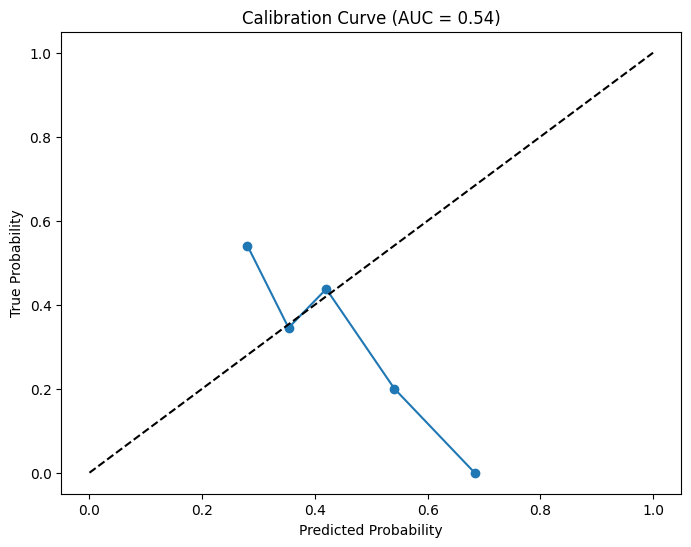

Brier Score: 0.23


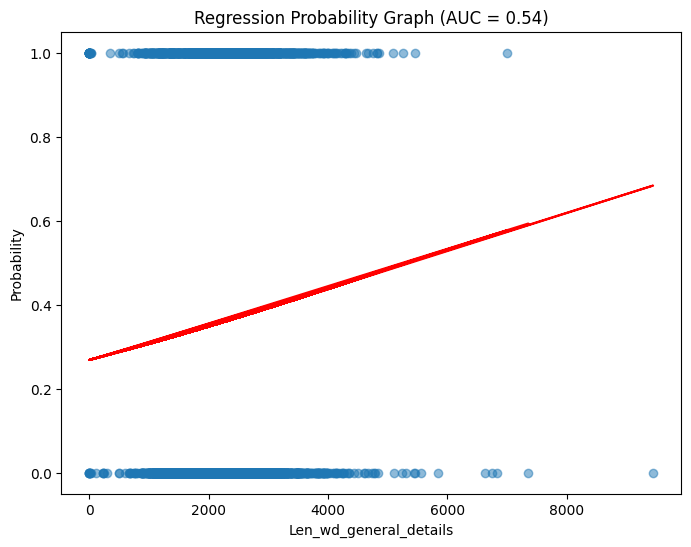

In [27]:
x=description_Final[['Len_wd_general_details','bedrooms']]
y=description_Final[['churn']]
multi_variable_logistic_regression(x, y, ['Len_wd_general_details'])

In [39]:
import statsmodels.api as sm
from sklearn.calibration import calibration_curve
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, roc_curve, roc_auc_score, classification_report,
    brier_score_loss, log_loss
)
import matplotlib.pyplot as plt
import seaborn as sns

def logistic_regression_analysis(data, target, features):
    results = {}

    for i in range(1, len(features) + 1):
        current_features = features[:i]
        X = data[current_features]
        y = data[target]

        # Statsmodels Logistic Regression
        X_sm = sm.add_constant(X)
        logit_model = sm.Logit(y, X_sm).fit(disp=0)

        # Scikit-learn Logistic Regression
        clf = LogisticRegression()
        clf.fit(X, y)
        y_pred = clf.predict(X)
        y_prob = clf.predict_proba(X)[:, 1]

        # Confusion Matrix
        cm = confusion_matrix(y, y_pred)

        # ROC Curve and AUC
        fpr, tpr, _ = roc_curve(y, y_prob)
        auc = roc_auc_score(y, y_prob)

        # Classification Report
        class_report = classification_report(y, y_pred, output_dict=True)
        class_report_str = classification_report(y, y_pred)

        # Log Likelihood
        log_likelihood = logit_model.llf

        # Deviance
        null_deviance = -2 * logit_model.llnull
        model_deviance = -2 * logit_model.llf
        deviance = null_deviance - model_deviance

        # Brier Score
        brier_score = brier_score_loss(y, y_prob)

        # Calibration Curve
        prob_true, prob_pred = calibration_curve(y, y_prob, n_bins=10)

        # Store results
        results[f'features_{i}'] = {
            'confusion_matrix': cm,
            'roc_curve': (fpr, tpr),
            'auc': auc,
            'classification_report': class_report,
            'log_likelihood': log_likelihood,
            'deviance': deviance,
            'brier_score': brier_score,
            'calibration_curve': (prob_true, prob_pred)
        }

        # Plotting
        fig, axs = plt.subplots(4, 2, figsize=(15, 20))
        fig.suptitle(f'Logistic Regression with {i} Features')

        # Confusion Matrix
        sns.heatmap(cm, annot=True, fmt="d", ax=axs[0, 0])
        axs[0, 0].set_title('Confusion Matrix')
        axs[0, 0].set_xlabel('Predicted')
        axs[0, 0].set_ylabel('Actual')
        # axs[0, 0].text(0.5, -0.2, 'Interpretation: The confusion matrix shows the count of true positive, false positive, true negative, and false negative predictions.', 
                        # transform=axs[0, 0].transAxes, fontsize=10, va='top', ha='center')

        # ROC Curve
        axs[0, 1].plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        axs[0, 1].plot([0, 1], [0, 1], linestyle='--')
        axs[0, 1].set_title('ROC Curve')
        axs[0, 1].set_xlabel('False Positive Rate')
        axs[0, 1].set_ylabel('True Positive Rate')
        axs[0, 1].legend()
        # axs[0, 1].text(0.5, -0.2, 'Interpretation: The ROC curve plots the true positive rate against the false positive rate. AUC indicates the area under this curve.', 
        #                 transform=axs[0, 1].transAxes, fontsize=10, va='top', ha='center')

        # Log Likelihood
        axs[1, 0].bar(['Log Likelihood'], [log_likelihood])
        axs[1, 0].set_title('Log Likelihood')
        # axs[1, 0].text(0.5, -0.2, 'Interpretation: Log Likelihood measures the goodness of fit of the model. Higher values indicate better fit.', 
        #                 transform=axs[1, 0].transAxes, fontsize=10, va='top', ha='center')

        # Deviance
        axs[1, 1].bar(['Deviance'], [deviance])
        axs[1, 1].set_title('Deviance')
        # axs[1, 1].text(0.5, -0.2, 'Interpretation: Deviance is a measure of the difference between the fitted values and the observed values. Lower values indicate better fit.', 
        #                 transform=axs[1, 1].transAxes, fontsize=10, va='top', ha='center')

        # Calibration Curve
        axs[2, 0].plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
        axs[2, 0].plot([0, 1], [0, 1], linestyle='--')
        axs[2, 0].set_title('Calibration Curve')
        axs[2, 0].set_xlabel('Mean Predicted Probability')
        axs[2, 0].set_ylabel('Fraction of Positives')
        axs[2, 0].legend()
        # axs[2, 0].text(0.5, -0.2, 'Interpretation: The calibration curve shows the relationship between predicted probabilities and the actual fraction of positives. Closer to the diagonal line indicates better calibration.', 
        #                 transform=axs[2, 0].transAxes, fontsize=10, va='top', ha='center')

        # Brier Score
        axs[2, 1].bar(['Brier Score'], [brier_score])
        axs[2, 1].set_title('Brier Score')
        # axs[2, 1].text(0.5, -0.2, 'Interpretation: Brier Score measures the mean squared difference between predicted probabilities and the actual outcome. Lower values indicate better predictions.', 
        #                 transform=axs[2, 1].transAxes, fontsize=10, va='top', ha='center')

        # Classification Report
        axs[3, 0].axis('off')
        axs[3, 0].text(0.5, 0.5, class_report_str, ha='center', va='center', fontsize=12)
        axs[3, 0].set_title('Classification Report')
        # axs[3, 0].text(0.5, -0.1, 'Interpretation: The classification report provides precision, recall, f1-score, and support for each class.', 
        #                 transform=axs[3, 0].transAxes, fontsize=10, va='top', ha='center')

        # Statistical Summary
        summary_str = logit_model.summary2().as_text()
        axs[3, 1].axis('off')
        axs[3, 1].text(0.5, 0.5, summary_str, ha='center', va='center', fontsize=12)
        axs[3, 1].set_title('Statistical Summary')
        # axs[3, 1].text(0.5, -0.1, 'Interpretation: The statistical summary provides detailed information about the logistic regression model, including coefficients, standard errors, and p-values.', 
        #                 transform=axs[3, 1].transAxes, fontsize=10, va='top', ha='center')

        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()

    return results

# Example usage
# data = pd.read_csv('your_data.csv')
# target = 'your_target_column'
# features = ['feature1', 'feature2', 'feature3']
# logistic_regression_analysis(data, target, features)



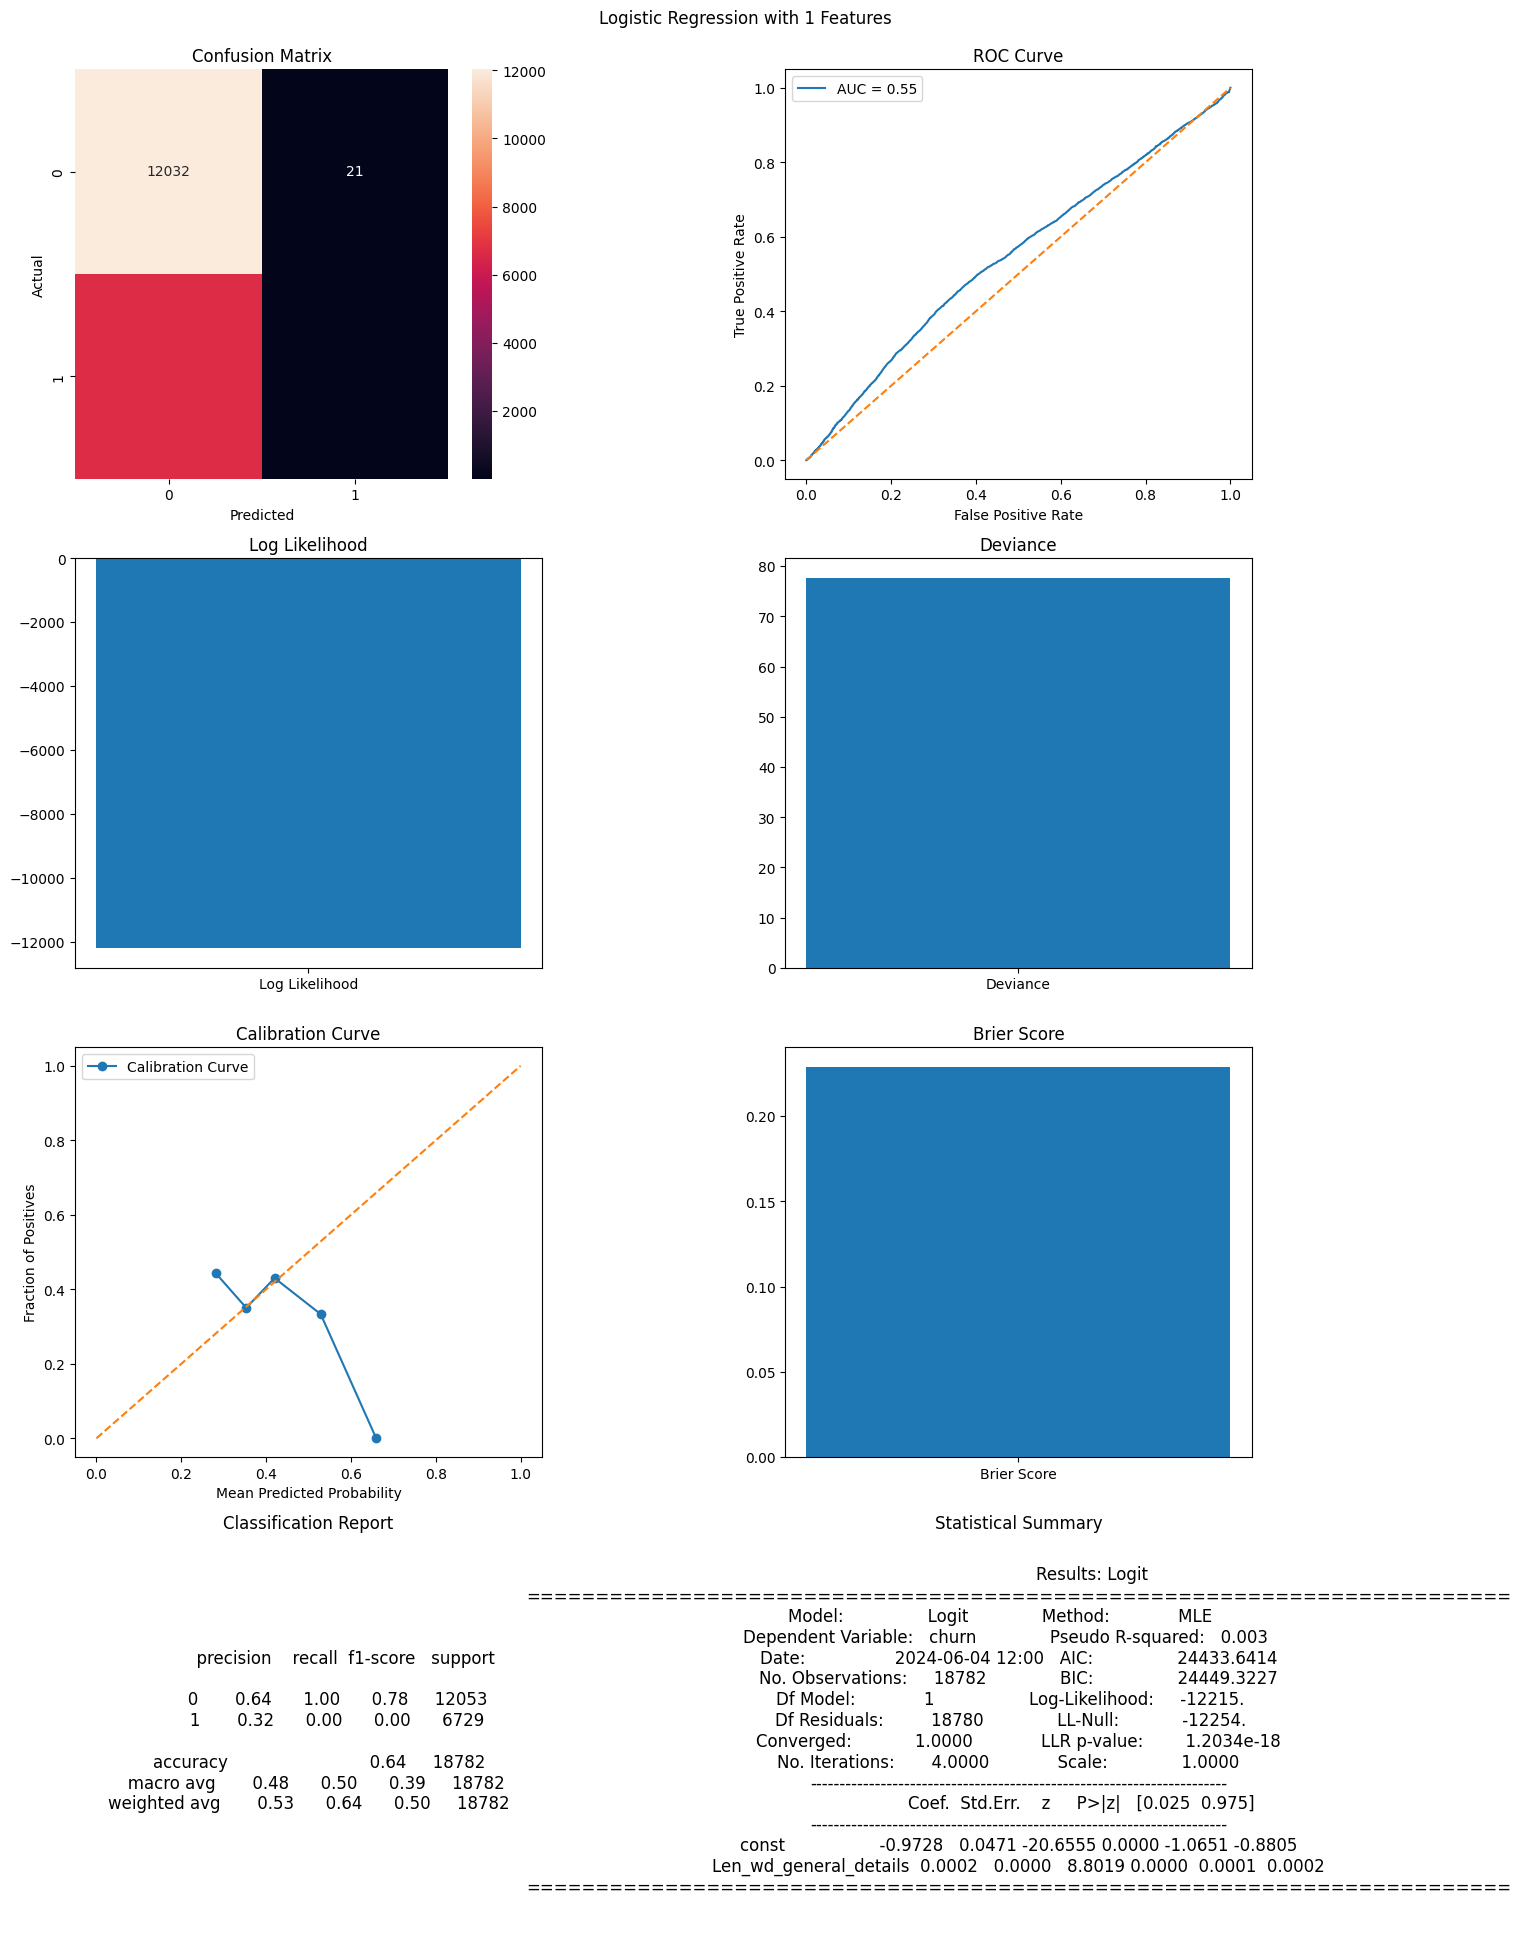

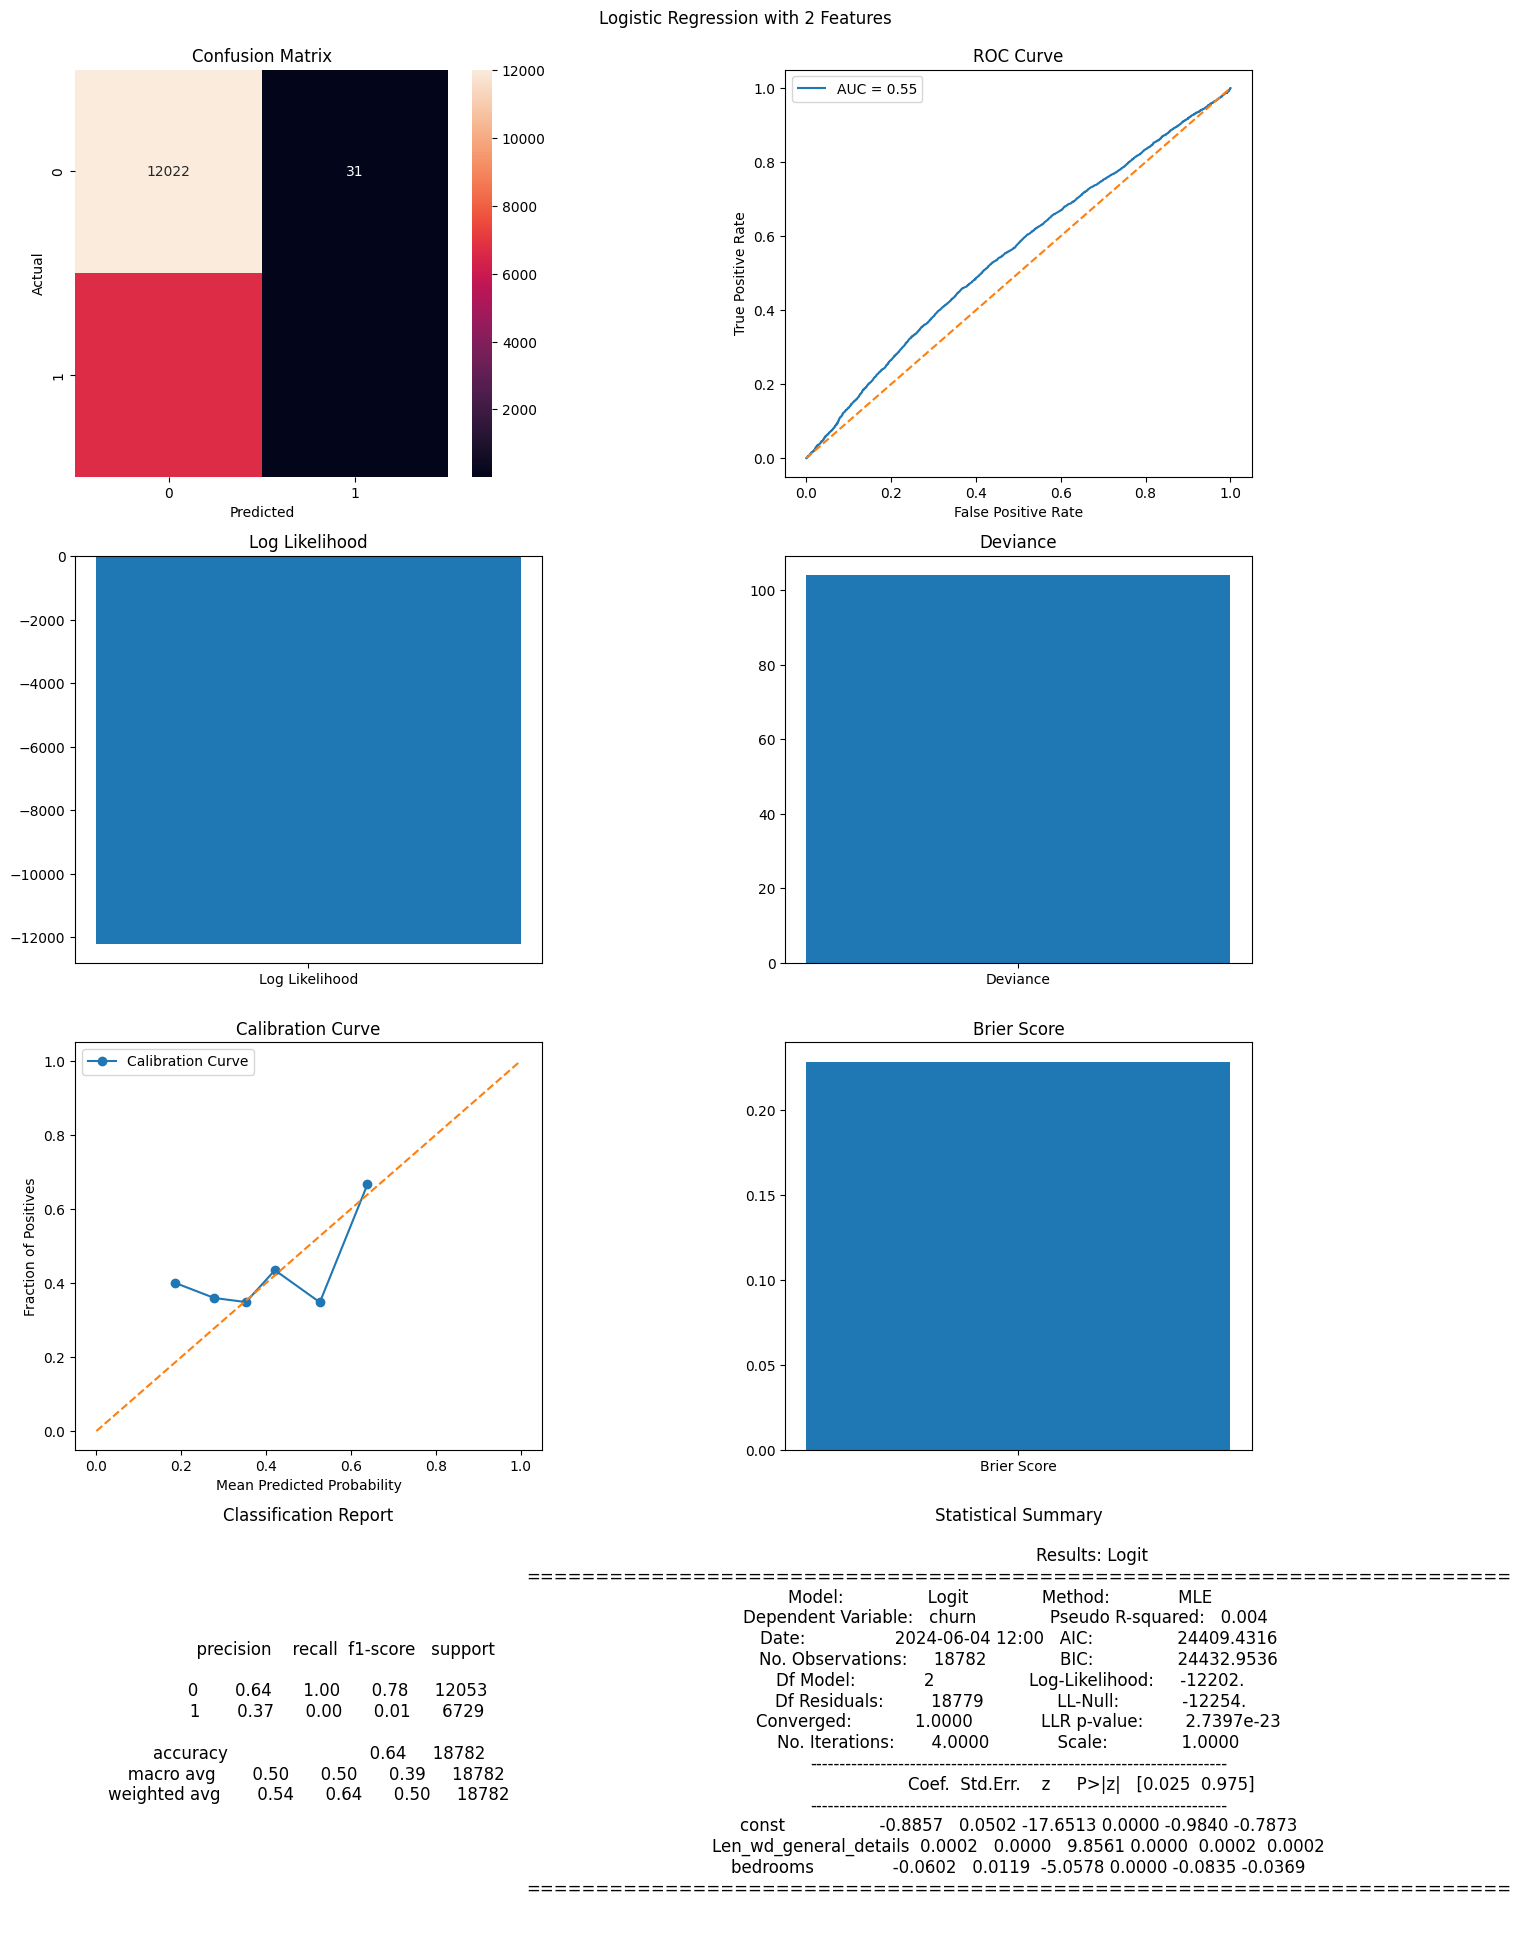

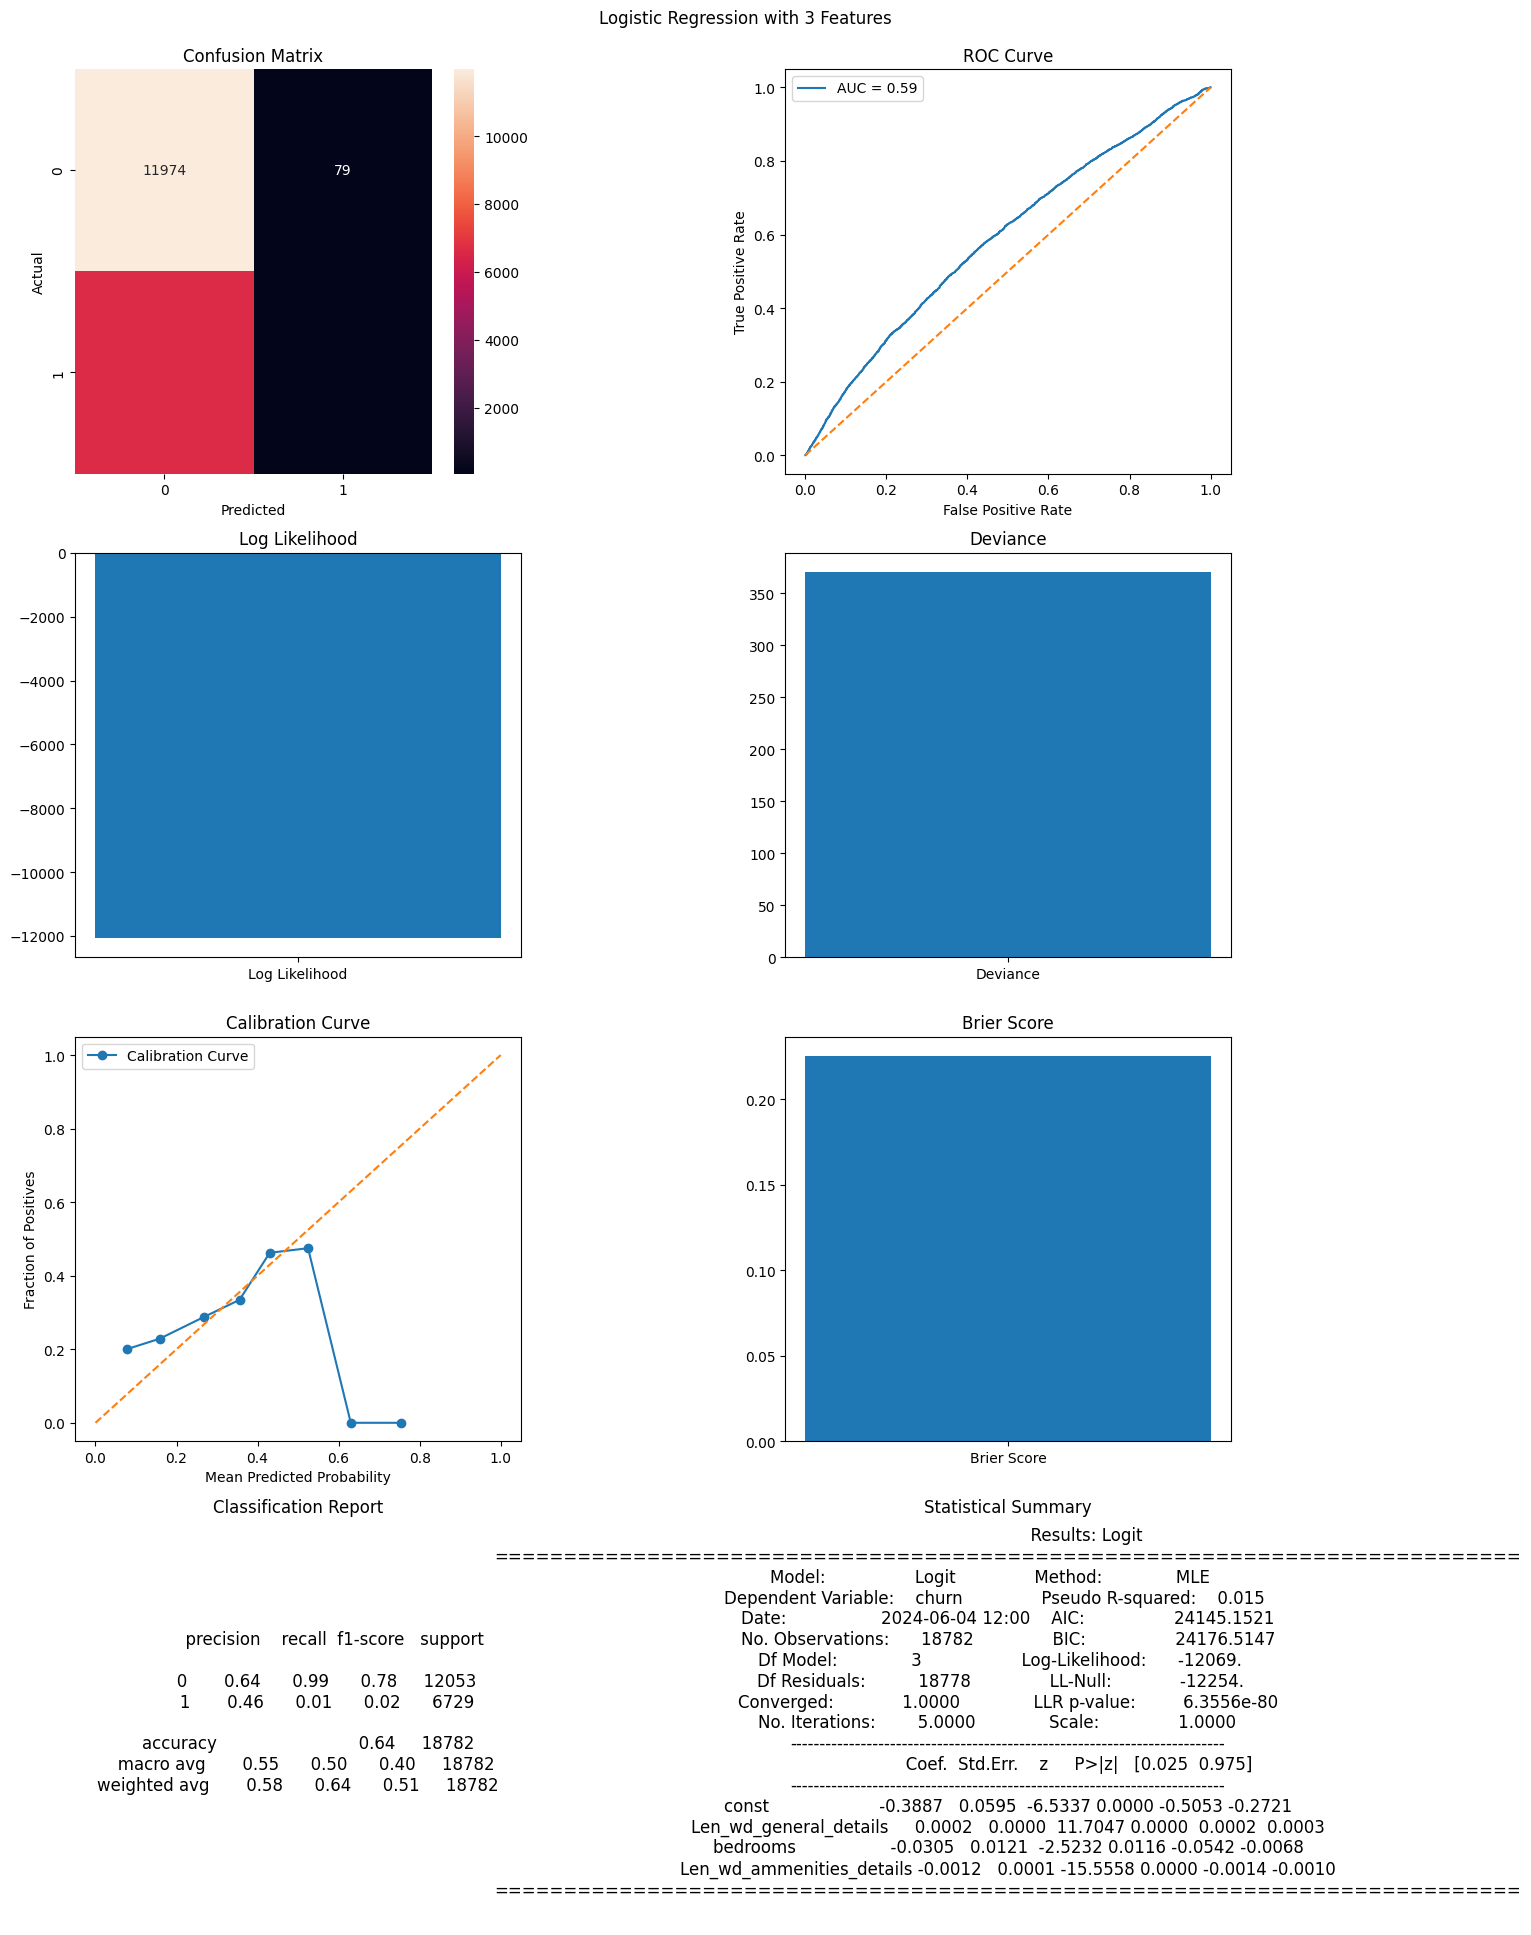

MissingDataError: exog contains inf or nans

In [45]:
target = 'churn'  # Replace with the actual column name of your target variable
features = ['Len_wd_general_details','bedrooms','Len_wd_ammenities_details','Flesch_wd_general_details']  # Replace with the actual column names of your features

# Call the logistic_regression_analysis function
results = logistic_regression_analysis(description_Final, target, features)

In [51]:
import statsmodels.api as sm
from sklearn.calibration import calibration_curve
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, roc_curve, roc_auc_score, classification_report,
    brier_score_loss, log_loss
)
import matplotlib.pyplot as plt
import seaborn as sns

def logistic_regression_analysis(data, target, features):
    results = {}

    for i in range(1, len(features) + 1):
        current_features = features[:i]
        X = data[current_features]
        y = data[target]

        # Statsmodels Logistic Regression
        X_sm = sm.add_constant(X)
        logit_model = sm.Logit(y, X_sm).fit(disp=0)

        # Scikit-learn Logistic Regression
        clf = LogisticRegression()
        clf.fit(X, y)
        y_pred = clf.predict(X)
        y_prob = clf.predict_proba(X)[:, 1]

        # Confusion Matrix
        cm = confusion_matrix(y, y_pred)

        # ROC Curve and AUC
        fpr, tpr, _ = roc_curve(y, y_prob)
        auc = roc_auc_score(y, y_prob)

        # Classification Report
        class_report = classification_report(y, y_pred, output_dict=True)
        class_report_str = classification_report(y, y_pred)

        # Log Likelihood
        log_likelihood = logit_model.llf

        # Deviance
        null_deviance = -2 * logit_model.llnull
        model_deviance = -2 * logit_model.llf
        deviance = null_deviance - model_deviance

        # Brier Score
        brier_score = brier_score_loss(y, y_prob)

        # Calibration Curve
        prob_true, prob_pred = calibration_curve(y, y_prob, n_bins=10)

        # Store results
        results[f'features_{i}'] = {
            'confusion_matrix': cm,
            'roc_curve': (fpr, tpr),
            'auc': auc,
            'classification_report': class_report,
            'log_likelihood': log_likelihood,
            'deviance': deviance,
            'brier_score': brier_score,
            'calibration_curve': (prob_true, prob_pred)
        }


        
        # Plotting
        fig, axs = plt.subplots(4, 2, figsize=(15, 20))
        fig.suptitle(f'Logistic Regression with {i} Features')

        # Confusion Matrix
        sns.heatmap(cm, annot=True, fmt="d", ax=axs[0, 0])
        axs[0, 0].set_title('Confusion Matrix')
        axs[0, 0].set_xlabel('Predicted')
        axs[0, 0].set_ylabel('Actual')

        # ROC Curve
        axs[0, 1].plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        axs[0, 1].plot([0, 1], [0, 1], linestyle='--')
        axs[0, 1].set_title('ROC Curve')
        axs[0, 1].set_xlabel('False Positive Rate')
        axs[0, 1].set_ylabel('True Positive Rate')
        axs[0, 1].legend()

        # Log Likelihood
        axs[1, 0].bar(['Log Likelihood'], [log_likelihood])
        axs[1, 0].set_title('Log Likelihood')

        # Deviance
        axs[1, 1].bar(['Deviance'], [deviance])
        axs[1, 1].set_title('Deviance')

        # Calibration Curve
        axs[2, 0].plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
        axs[2, 0].plot([0, 1], [0, 1], linestyle='--')
        axs[2, 0].set_title('Calibration Curve')
        axs[2, 0].set_xlabel('Mean Predicted Probability')
        axs[2, 0].set_ylabel('Fraction of Positives')
        axs[2, 0].legend()

        # Brier Score
        axs[2, 1].bar(['Brier Score'], [brier_score])
        axs[2, 1].set_title('Brier Score')

        # Classification Report
        axs[3, 0].axis('off')
        axs[3, 0].text(0.5, 0.5, class_report_str, ha='center', va='center', fontsize=12)
        axs[3, 0].set_title('Classification Report')

        # Statistical Summary
        summary_str = logit_model.summary2().as_text()
        axs[3, 1].axis('off')
        axs[3, 1].text(0.5, 0.5, summary_str, ha='center', va='center', fontsize=12)
        axs[3, 1].set_title('Statistical Summary')

        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()

        # Detailed Analysis
        print(f"Analysis with {i} features:")
        print("Confusion Matrix:")
        print(cm)
        print("Interpretation: The confusion matrix shows the count of true positives, false positives, true negatives, and false negatives.")
        print("\nClassification Report:")
        print(class_report_str)
        print("Interpretation: The classification report provides precision, recall, f1-score, and support for each class.")
        print("\nAUC Score:")
        print(f"AUC: {auc:.2f}")
        if auc < 0.80:
            print("Interpretation: AUC below 0.80 is generally considered not very good.")
        else:
            print("Interpretation: AUC above 0.80 is generally considered good.")
        print("\nBrier Score:")
        print(f"Brier Score: {brier_score:.4f}")
        print("Interpretation: Lower Brier Score indicates better predictions.")
        print("\nLog Likelihood:")
        print(f"Log Likelihood: {log_likelihood:.2f}")
        print("Interpretation: Higher log likelihood indicates better fit of the model.")
        print("\nDeviance:")
        print(f"Deviance: {deviance:.2f}")
        print("Interpretation: Lower deviance indicates better fit of the model.")

    return results

# Example usage
# data = pd.read_csv('your_data.csv')
# target = 'your_target_column'
# features = ['feature1', 'feature2', 'feature3']
# logistic_regression_analysis(data, target, features)


C:\Users\DeepankarSrigyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



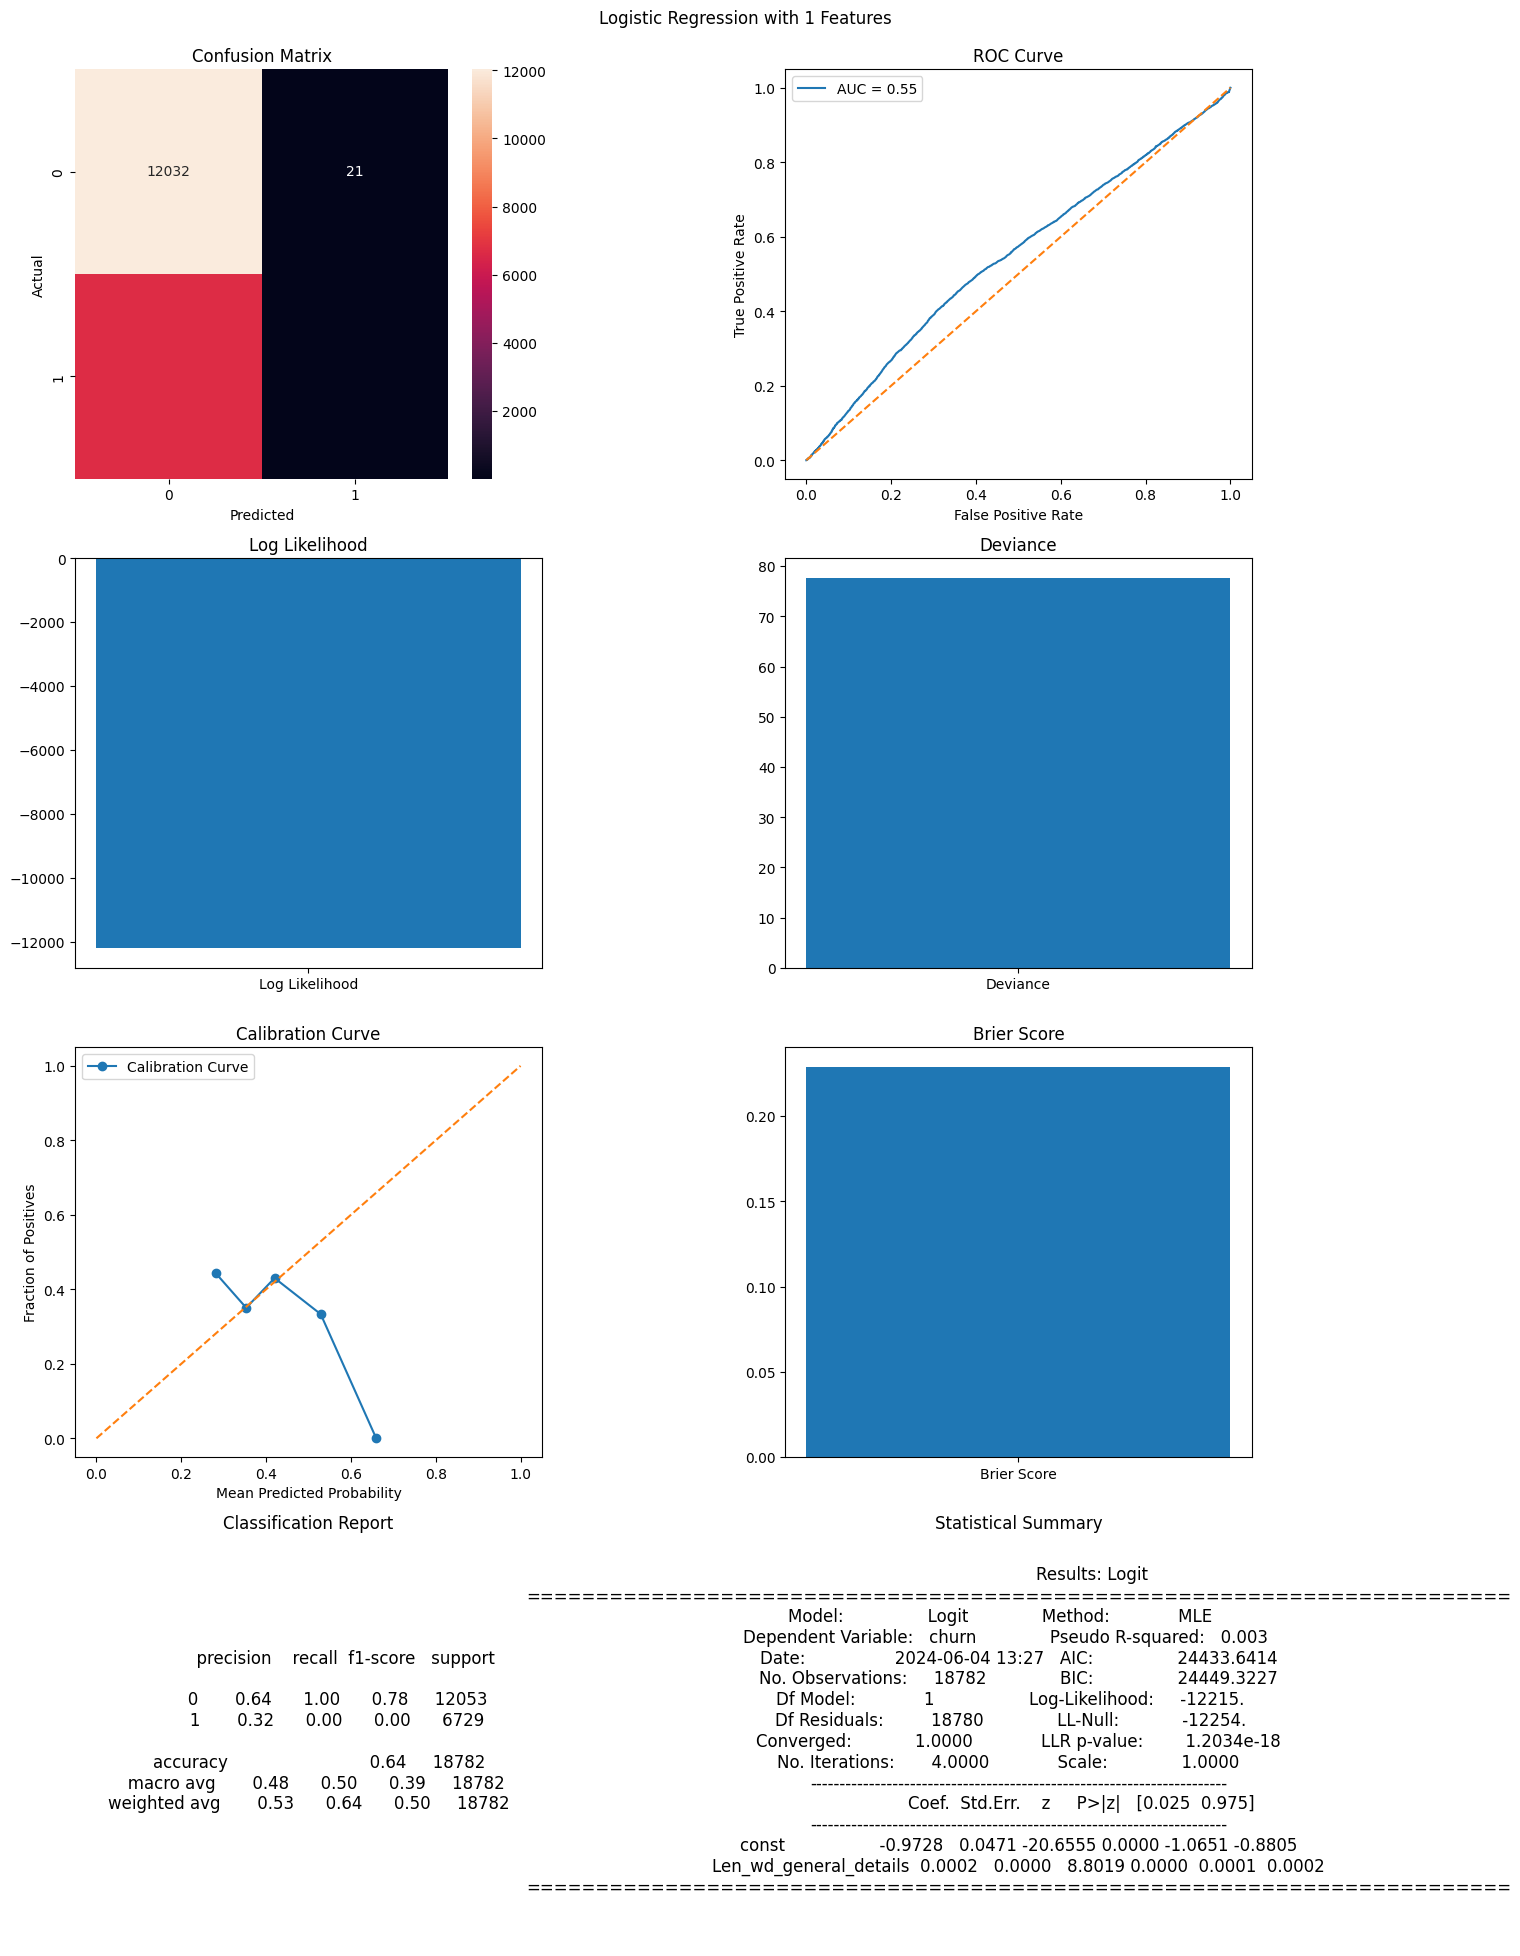

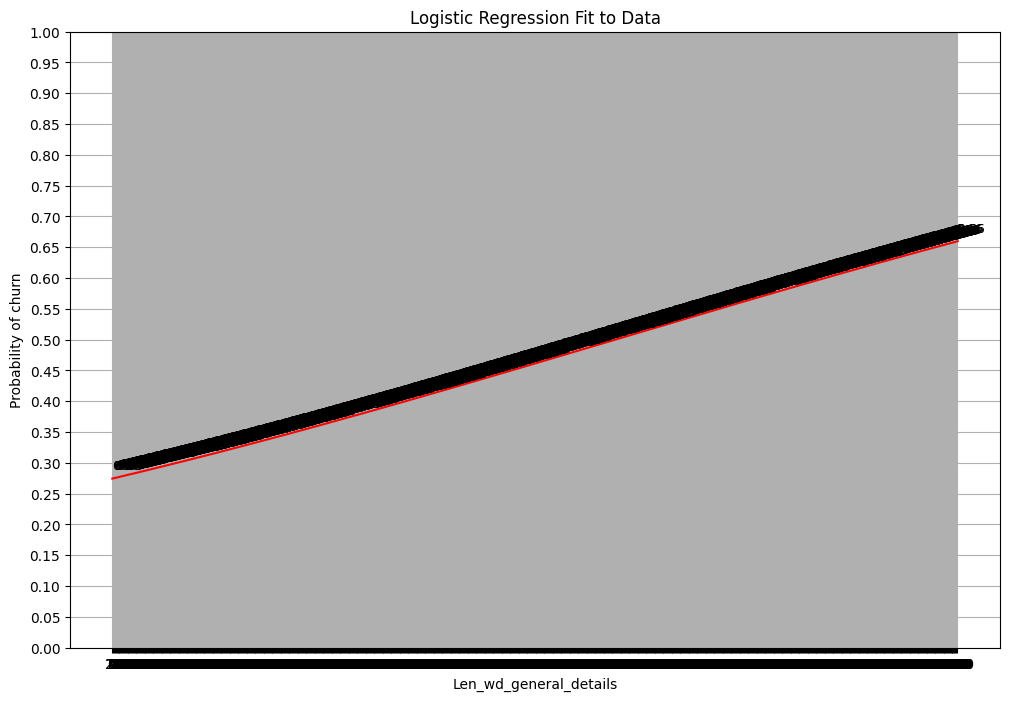

Analysis with 1 features:
Confusion Matrix:
[[12032    21]
 [ 6719    10]]
Interpretation: The confusion matrix shows the count of true positives, false positives, true negatives, and false negatives.

Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78     12053
           1       0.32      0.00      0.00      6729

    accuracy                           0.64     18782
   macro avg       0.48      0.50      0.39     18782
weighted avg       0.53      0.64      0.50     18782

Interpretation: The classification report provides precision, recall, f1-score, and support for each class.

AUC Score:
AUC: 0.55
Interpretation: AUC below 0.80 is generally considered not very good.

Brier Score:
Brier Score: 0.2289
Interpretation: Lower Brier Score indicates better predictions.

Log Likelihood:
Log Likelihood: -12214.82
Interpretation: Higher log likelihood indicates better fit of the model.

Deviance:
Deviance: 77.69
Interpr

C:\Users\DeepankarSrigyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



ValueError: X has 1 features, but LogisticRegression is expecting 2 features as input.

In [54]:
target = 'churn'  # Replace with the actual column name of your target variable
features = ['Len_wd_general_details','bedrooms','Len_wd_ammenities_details']  # Replace with the actual column names of your features

# Call the logistic_regression_analysis function
results = logistic_regression_analysis(description_Final, target, features)

In [56]:
import statsmodels.api as sm
from sklearn.calibration import calibration_curve
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, roc_curve, roc_auc_score, classification_report,
    brier_score_loss, log_loss
)
import matplotlib.pyplot as plt
import seaborn as sns

def logistic_regression_analysis(data, target, features):
    results = {}

    for i in range(1, len(features) + 1):
        current_features = features[:i]
        X = data[current_features]
        y = data[target]

        # Statsmodels Logistic Regression
        X_sm = sm.add_constant(X)
        logit_model = sm.Logit(y, X_sm).fit(disp=0)

        # Scikit-learn Logistic Regression
        clf = LogisticRegression()
        clf.fit(X, y)
        y_pred = clf.predict(X)
        y_prob = clf.predict_proba(X)[:, 1]

        # Confusion Matrix
        cm = confusion_matrix(y, y_pred)

        # ROC Curve and AUC
        fpr, tpr, _ = roc_curve(y, y_prob)
        auc = roc_auc_score(y, y_prob)

        # Classification Report
        class_report = classification_report(y, y_pred, output_dict=True)
        class_report_str = classification_report(y, y_pred)

        # Log Likelihood
        log_likelihood = logit_model.llf

        # Deviance
        null_deviance = -2 * logit_model.llnull
        model_deviance = -2 * logit_model.llf
        deviance = null_deviance - model_deviance

        # Brier Score
        brier_score = brier_score_loss(y, y_prob)

        # Calibration Curve
        prob_true, prob_pred = calibration_curve(y, y_prob, n_bins=10)

        # Logistic Regression Fit and Predictions for a Smooth Curve
        X_test = np.arange(X[current_features[0]].min(), X[current_features[0]].max() + 1).reshape(-1, 1)
        y_pred_smooth = clf.predict_proba(X_test)[:, 1]

        # Store results
        results[f'features_{i}'] = {
            'confusion_matrix': cm,
            'roc_curve': (fpr, tpr),
            'auc': auc,
            'classification_report': class_report,
            'log_likelihood': log_likelihood,
            'deviance': deviance,
            'brier_score': brier_score,
            'calibration_curve': (prob_true, prob_pred),
            'logistic_regression_predictions': pd.DataFrame({
                current_features[0]: X_test.ravel(),
                'Probability': y_pred_smooth
            })
        }

        # Plotting
        fig, axs = plt.subplots(4, 2, figsize=(15, 20))
        fig.suptitle(f'Logistic Regression with {i} Features')

        # Confusion Matrix
        sns.heatmap(cm, annot=True, fmt="d", ax=axs[0, 0])
        axs[0, 0].set_title('Confusion Matrix')
        axs[0, 0].set_xlabel('Predicted')
        axs[0, 0].set_ylabel('Actual')

        # ROC Curve
        axs[0, 1].plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        axs[0, 1].plot([0, 1], [0, 1], linestyle='--')
        axs[0, 1].set_title('ROC Curve')
        axs[0, 1].set_xlabel('False Positive Rate')
        axs[0, 1].set_ylabel('True Positive Rate')
        axs[0, 1].legend()

        # Log Likelihood
        axs[1, 0].bar(['Log Likelihood'], [log_likelihood])
        axs[1, 0].set_title('Log Likelihood')

        # Deviance
        axs[1, 1].bar(['Deviance'], [deviance])
        axs[1, 1].set_title('Deviance')

        # Calibration Curve
        axs[2, 0].plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
        axs[2, 0].plot([0, 1], [0, 1], linestyle='--')
        axs[2, 0].set_title('Calibration Curve')
        axs[2, 0].set_xlabel('Mean Predicted Probability')
        axs[2, 0].set_ylabel('Fraction of Positives')
        axs[2, 0].legend()

        # Brier Score
        axs[2, 1].bar(['Brier Score'], [brier_score])
        axs[2, 1].set_title('Brier Score')

        # Classification Report
        axs[3, 0].axis('off')
        axs[3, 0].text(0.5, 0.5, class_report_str, ha='center', va='center', fontsize=12)
        axs[3, 0].set_title('Classification Report')

        # Statistical Summary
        summary_str = logit_model.summary2().as_text()
        axs[3, 1].axis('off')
        axs[3, 1].text(0.5, 0.5, summary_str, ha='center', va='center', fontsize=12)
        axs[3, 1].set_title('Statistical Summary')

        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()

        # Logistic Regression Fit Plot
        plt.figure(figsize=(12, 8))
        plt.plot(X_test.ravel(), y_pred_smooth, color='red')  # regression line
        plt.title('Logistic Regression Fit to Data')
        plt.xlabel(current_features[0])
        plt.ylabel('Probability of ' + target)
        plt.yticks(np.arange(0, 1 + 0.05, 0.05))  # Adjusts the range and interval of y-axis ticks
        plt.xticks(np.arange(0, X[current_features[0]].max() + 1, 10))  # Ticks every 10 units from 0 to max

        # Define ticks manually to include min and max explicitly
        min_tick = X_test.min()
        max_tick = X_test.max()
        tick_interval = 10
        ticks = np.arange(min_tick, max_tick + 1, tick_interval)  # ensures inclusion of max_tick
        plt.xticks(ticks)  # Set the ticks

        # Labeling probabilities at the manually set x-ticks
        for tick in ticks:  # Use the manually defined ticks
            idx = np.where(X_test.ravel() == tick)  # Find the index where X_test matches the tick
            if idx[0].size > 0:  # Ensure the index array is not empty
                probability = y_pred_smooth[idx[0][0]]  # Access the first element of the index array
                plt.text(tick, probability + 0.01, f'{probability:.2f}', fontsize=9, verticalalignment='bottom')

        plt.grid(True)
        plt.show()

        # Detailed Analysis
        print(f"Analysis with {i} features:")
        print("Confusion Matrix:")
        print(cm)
        print("Interpretation: The confusion matrix shows the count of true positives, false positives, true negatives, and false negatives.")
        print("\nClassification Report:")
        print(class_report_str)
        print("Interpretation: The classification report provides precision, recall, f1-score, and support for each class.")
        print("\nAUC Score:")
        print(f"AUC: {auc:.2f}")
        if auc < 0.80:
            print("Interpretation: AUC below 0.80 is generally considered not very good.")
        else:
            print("Interpretation: AUC above 0.80 is generally considered good.")
        print("\nBrier Score:")
        print(f"Brier Score: {brier_score:.4f}")
        print("Interpretation: Lower Brier Score indicates better predictions.")
        print("\nLog Likelihood:")
        print(f"Log Likelihood: {log_likelihood:.2f}")
        print("Interpretation: Higher log likelihood indicates better fit of the model.")
        print("\nDeviance:")
        print(f"Deviance: {deviance:.2f}")
        print("Interpretation: Lower deviance indicates better fit of the model.")

    return results

# Example usage
# data = pd.read_csv('your_data.csv')
# target = 'your_target_column'
# features = ['feature1', 'feature2', 'feature3']
# logistic_regression_analysis(data, target, features)


C:\Users\DeepankarSrigyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



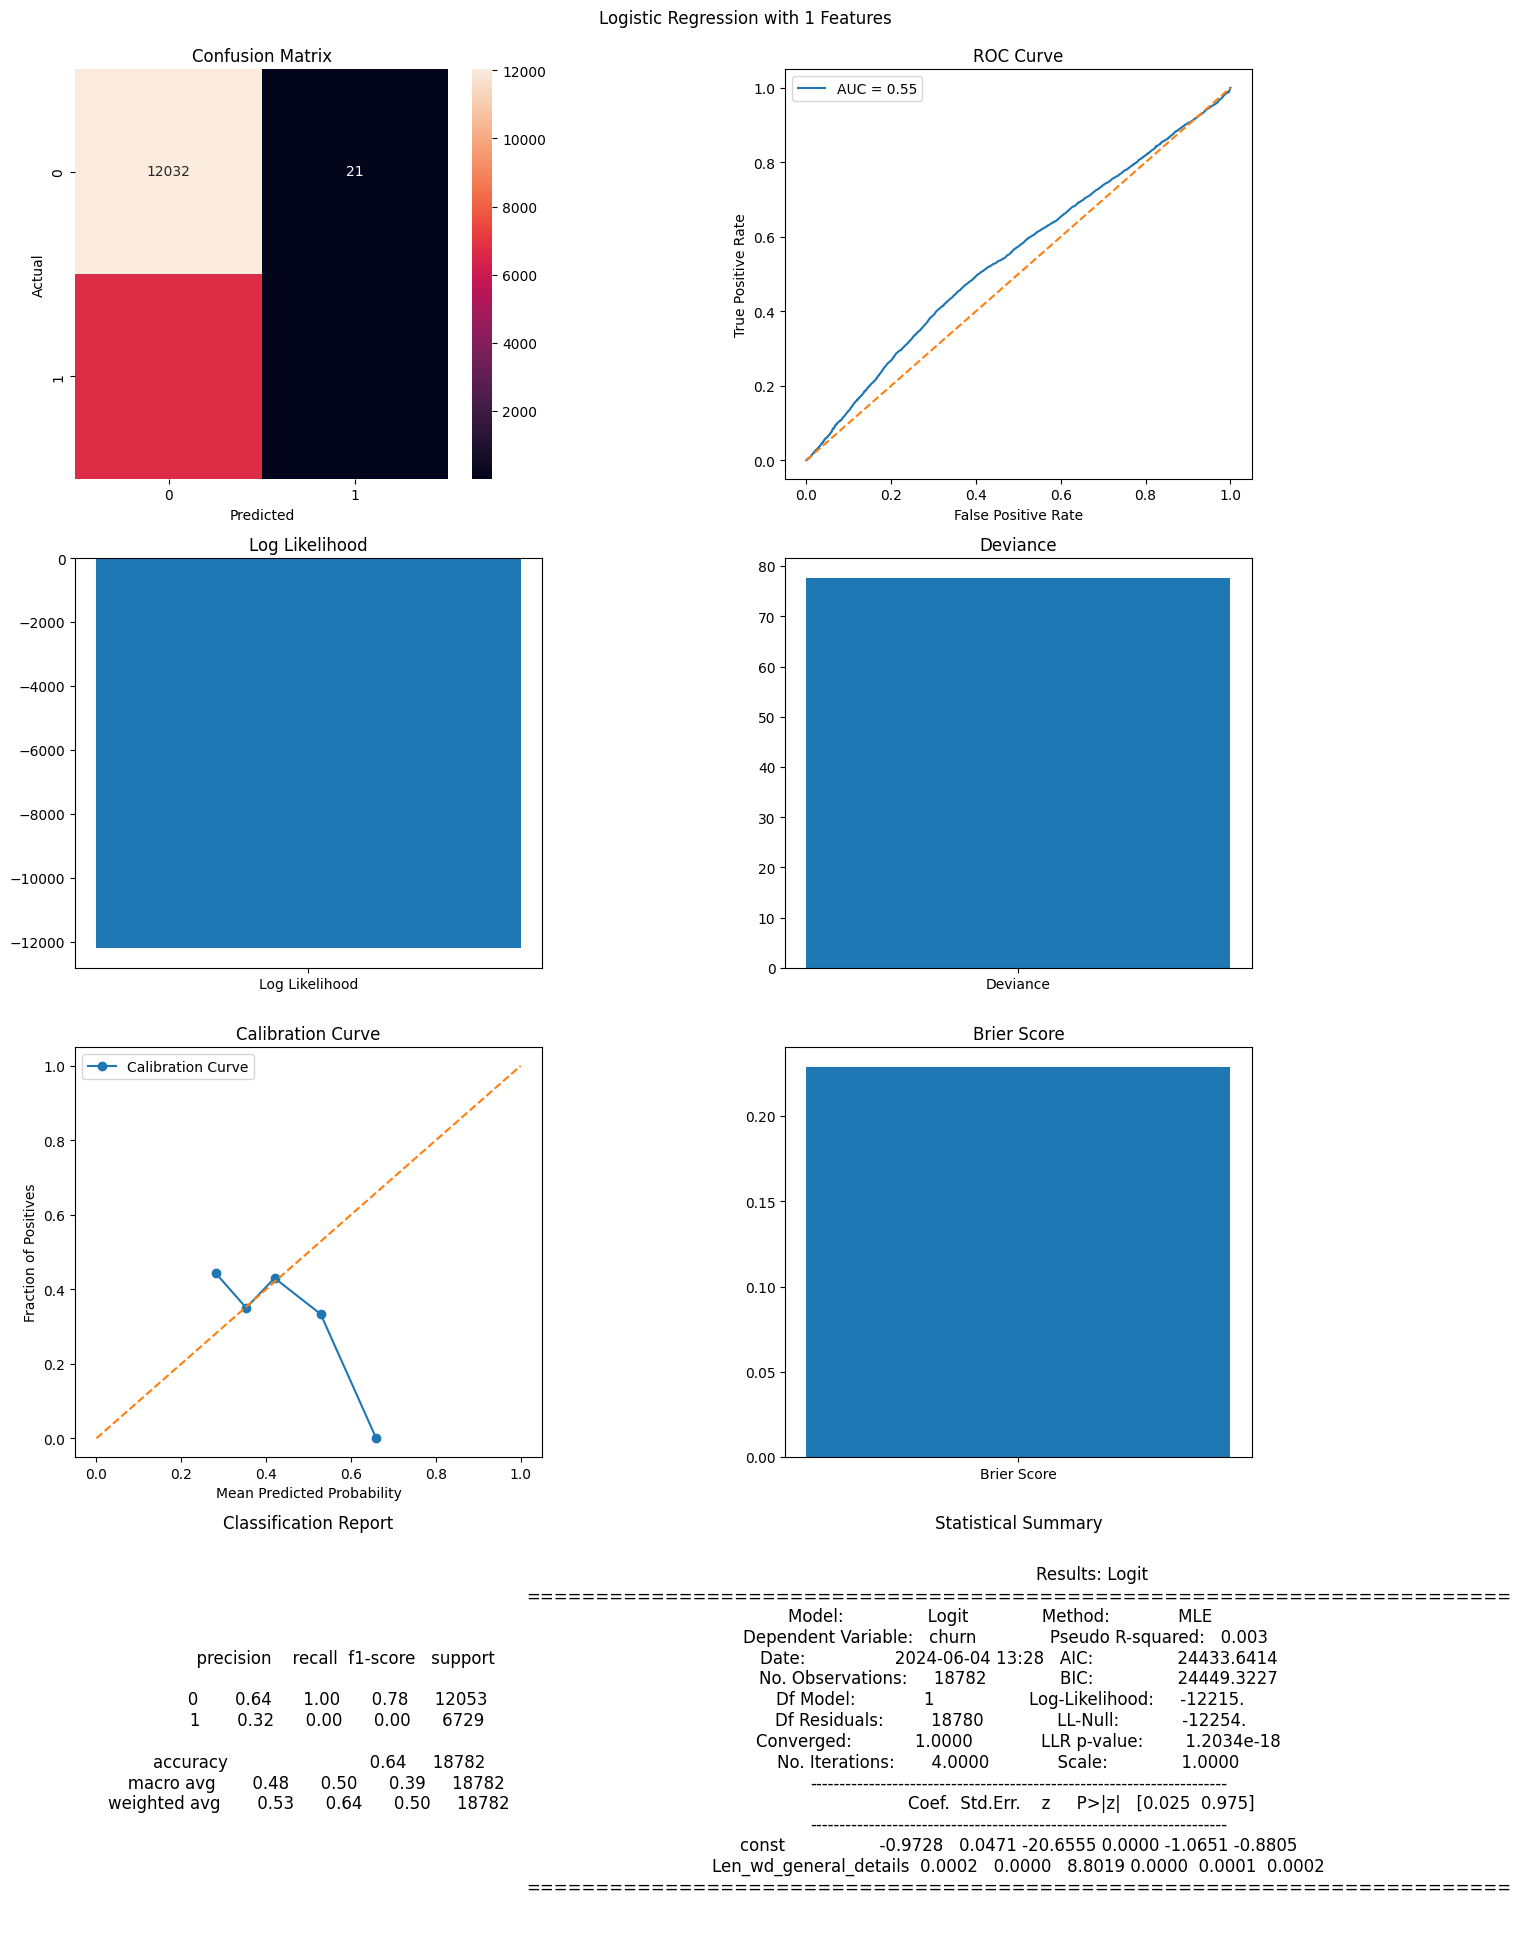

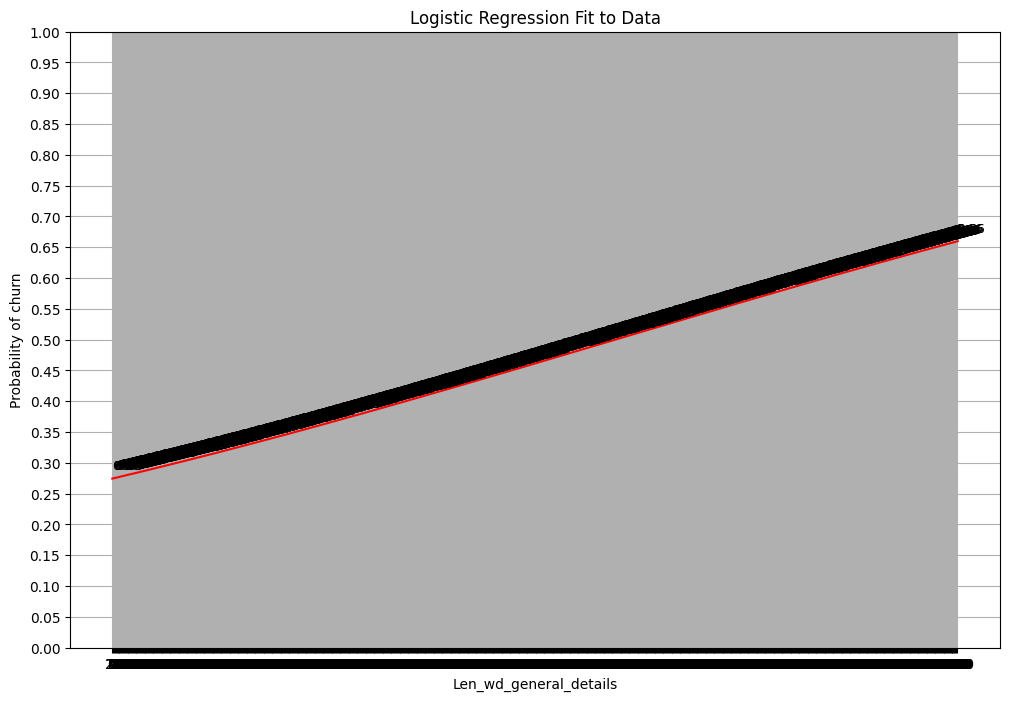

Analysis with 1 features:
Confusion Matrix:
[[12032    21]
 [ 6719    10]]
Interpretation: The confusion matrix shows the count of true positives, false positives, true negatives, and false negatives.

Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78     12053
           1       0.32      0.00      0.00      6729

    accuracy                           0.64     18782
   macro avg       0.48      0.50      0.39     18782
weighted avg       0.53      0.64      0.50     18782

Interpretation: The classification report provides precision, recall, f1-score, and support for each class.

AUC Score:
AUC: 0.55
Interpretation: AUC below 0.80 is generally considered not very good.

Brier Score:
Brier Score: 0.2289
Interpretation: Lower Brier Score indicates better predictions.

Log Likelihood:
Log Likelihood: -12214.82
Interpretation: Higher log likelihood indicates better fit of the model.

Deviance:
Deviance: 77.69
Interpr

C:\Users\DeepankarSrigyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



ValueError: X has 1 features, but LogisticRegression is expecting 2 features as input.

In [57]:
target = 'churn'  # Replace with the actual column name of your target variable
features = ['Len_wd_general_details','bedrooms','Len_wd_ammenities_details']  # Replace with the actual column names of your features

# Call the logistic_regression_analysis function
results = logistic_regression_analysis(description_Final, target, features)

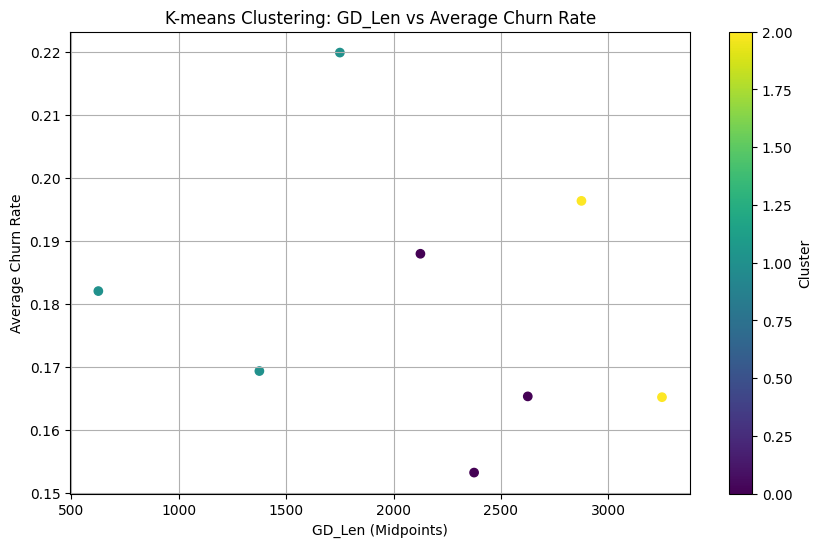

   GD_Len    2020    2021    2022    2023  Average_Churn  Cluster
0     625  0.1190  0.2286  0.1848  0.1957       0.182025        1
1    1375  0.1846  0.2000  0.1654  0.1273       0.169325        1
2    1750  0.1290  0.2696  0.1984  0.2826       0.219900        1
3    2125  0.1667  0.1304  0.2393  0.2154       0.187950        0
4    2375  0.1154  0.1782  0.1287  0.1905       0.153200        0
5    2625  0.0909  0.1524  0.2750  0.1429       0.165300        0
6    2875  0.1129  0.2051  0.2174  0.2500       0.196350        2
7    3250  0.0769  0.1038  0.2800  0.2000       0.165175        2


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Data
data = {
    'GD_Len': ['1-1250', '1251-1500', '1501-2000', '2001-2250', '2250-2500', '2501-2750', '2751-3000', '>3000'],
    '2020': [0.119, 0.1846, 0.129, 0.1667, 0.1154, 0.0909, 0.1129, 0.0769],
    '2021': [0.2286, 0.2, 0.2696, 0.1304, 0.1782, 0.1524, 0.2051, 0.1038],
    '2022': [0.1848, 0.1654, 0.1984, 0.2393, 0.1287, 0.275, 0.2174, 0.28],
    '2023': [0.1957, 0.1273, 0.2826, 0.2154, 0.1905, 0.1429, 0.25, 0.2]
}

# Convert property size to numeric midpoints for analysis
midpoints = [625, 1375, 1750, 2125, 2375, 2625, 2875, 3250]
data['GD_Len'] = midpoints

df = pd.DataFrame(data)

# Calculate average churn rate for each property size range
df['Average_Churn'] = df[['2020', '2021', '2022', '2023']].mean(axis=1)

# Prepare data for K-means clustering
X = df[['GD_Len', 'Average_Churn']]

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
df['Cluster'] = kmeans.fit_predict(X)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df['GD_Len'], df['Average_Churn'], c=df['Cluster'], cmap='viridis', label='Cluster')
plt.xlabel('GD_Len (Midpoints)')
plt.ylabel('Average Churn Rate')
plt.title('K-means Clustering: GD_Len vs Average Churn Rate')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Display the dataframe with cluster assignments
print(df)


In [25]:
description_Final.groupby(by=(['Bedrooms'])

SyntaxError: incomplete input (3453243454.py, line 1)

In [30]:
grouped_df = description_Final.groupby(['bedrooms', 'churn','Len_wd_general_details']).agg({'churn': 'sum','propertyid': 'count'})  # Example to show aggregation of other fields}).reset_index()
grouped_df

churn  propertyid
bedrooms churn Len_wd_general_details                   
0        0     0                           0           1
         1     0                           7           7
               891                         1           1
               1167                        1           1
               1776                        1           1
...                                      ...         ...
17       0     3678                        0           1
         1     3377                        1           1
               3684                        1           1
18       0     2253                        0           1
22       0     3039                        0           1

[11958 rows x 2 columns]

In [26]:
description_Final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18806 entries, 0 to 18805
Data columns (total 35 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   propertyid                              18806 non-null  int64  
 1   propertyreference                       18806 non-null  int64  
 2   propertylivedate                        18806 non-null  object 
 3   DateToldWithdrawingLocal                6752 non-null   object 
 4   bedrooms                                18806 non-null  int64  
 5   propertyType                            18806 non-null  object 
 6   sleeps                                  18803 non-null  float64
 7   location                                18804 non-null  object 
 8   churn                                   18806 non-null  int64  
 9   valid_from                              18806 non-null  object 
 10  valid_to                                40 non-null     ob

In [32]:
text = "Nestled amidst the picturesque landscapes of Abererch near Pwllheli, sits a delightful cottage on a working farm, where the essence of rural charm and tranquil living converge.This quaint abode exudes warmth and coziness, inviting guests to immerse themselves in its homely embrace. As you approach, the rustic allure of the cottage is immediately apparent.The surrounding fields stretch out, alive with the gentle hum of farm life, offering a serene backdrop for relaxation and reflection. Step inside, and you'll be greeted by a welcoming interior, infused with character and adorned with tasteful touches.The living spaces are thoughtfully arranged, featuring snug furnishings and rustic decor that beckon you to unwind.Sink into plush sofas where you can while away the hours with a good book or simply bask in the soothing ambiance. The cottage's kitchen is a focal point of comfort and culinary delight.Here, you'll find all the essentials to whip up delicious meals using fresh produce sourced locally.Whether you're savoring a leisurely breakfast at the table or preparing a hearty supper to be enjoyed al fresco in the garden, every moment promises to be a gastronomic delight. Take leisurely strolls along country lanes, or simply lounge in the sunshine with a glass of your favourite wine, savoring the simple pleasures of rural living. In this charming cottage on a working farm, every detail is imbued with a sense of relaxation and authenticity.Whether you're seeking a peaceful retreat to recharge your batteries or a base from which to explore the beauty of North Wales, this enchanting abode promises an unforgettable experience filled with warmth, flavor, and character."
char_count = len(text)
print(f"Character count: {char_count}")

Character count: 1688


In [35]:
import pandas as pd
from textblob import TextBlob

# Define a function to calculate sentiment analysis using TextBlob
def sentiment_analysis(text):
    return TextBlob(text).sentiment

# Define a function to calculate emotional analysis (replace with your preferred method)
def emotional_analysis(text):
    # You can replace this with your preferred emotional analysis method
    # For example, use the limbic_model.predict(text) function from the 'limbic' package
    # Note: The 'limbic' package is not available in my current environment
    return "Emotion analysis result"  # Replace with actual analysis

# Apply the sentiment analysis function to the 'description' column (skip null values)
description_Final['sentiment'] = description_Final['wd_general_details'].apply(lambda x: sentiment_analysis(x) if pd.notnull(x) else None)

# Apply the emotional analysis function to the 'description' column (skip null values)
description_Final['emotion'] = description_Final['wd_general_details'].apply(lambda x: emotional_analysis(x) if pd.notnull(x) else None)



# Print a success message
description_Final[['propertyid','wd_general_details','sentiment','emotion']]


C:\Users\DeepankarSrigyan\AppData\Local\Temp\ipykernel_16372\2561840791.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\DeepankarSrigyan\AppData\Local\Temp\ipykernel_16372\2561840791.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,propertyid,wd_general_details,sentiment,emotion
0,127056,Boasting a beautiful blue exterior and an equa...,"(0.3321995464852609, 0.5363378684807256)",Emotion analysis result
1,277826,"The Mill, nestled amidst the picturesque lands...","(0.2928571428571428, 0.5221938775510204)",Emotion analysis result
2,50037,A stunning barn conversion on the outskirts of...,"(0.625, 0.85)",Emotion analysis result
3,71687,Swifts is the larger of the two semi-detached ...,"(0.1852040816326531, 0.4048469387755102)",Emotion analysis result
4,51456,Oakamoor 1 mile. Barks Cottage is nestled in t...,"(0.3212117454304954, 0.5736396705146706)",Emotion analysis result
...,...,...,...,...
18801,284871,Set near the Yorkshire coast and within a col...,"(0.39890873015873013, 0.5552579365079365)",Emotion analysis result
18802,284836,Primrose is a delightful stone cottage nestled...,"(0.369, 0.5765555555555556)",Emotion analysis result
18803,284837,"Willow is a lovely semi-detached cottage, 1 of...","(0.31999999999999995, 0.6772222222222222)",Emotion analysis result
18804,284872,Rose is settled amidst delightful neighbouring...,"(0.2713383838383838, 0.5070165945165945)",Emotion analysis result


In [37]:
import pandas as pd
from textblob import TextBlob

# Define the function to extract subjectivity
def extract_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity if pd.notnull(text) else None

# Define a simple heuristic function to estimate objectivity
def estimate_objectivity(text):
    if pd.notnull(text):
        factual_keywords = ['released', 'units', 'data', 'statistics', 'results', 'observed']
        text_lower = text.lower()
        for keyword in factual_keywords:
            if keyword in text_lower:
                return 1.0  # High objectivity if any factual keyword is found
        return 0.0  # Low objectivity if no factual keyword is found
    else:
        return None

# Assuming description_Final is your DataFrame and wd_general_details is the column of interest
description_Final['subjectivity'] = description_Final['wd_general_details'].apply(extract_subjectivity)
description_Final['objectivity'] = description_Final['wd_general_details'].apply(estimate_objectivity)

# Display the result
print(description_Final[['wd_general_details', 'subjectivity', 'objectivity']])


C:\Users\DeepankarSrigyan\AppData\Local\Temp\ipykernel_16372\3586792063.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\DeepankarSrigyan\AppData\Local\Temp\ipykernel_16372\3586792063.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,propertyid,wd_general_details,sentiment,emotion
0,127056,Boasting a beautiful blue exterior and an equa...,0.332200,65.0
1,277826,"The Mill, nestled amidst the picturesque lands...",0.292857,77.0
2,50037,A stunning barn conversion on the outskirts of...,0.625000,10.0
3,71687,Swifts is the larger of the two semi-detached ...,0.185204,8.0
4,51456,Oakamoor 1 mile. Barks Cottage is nestled in t...,0.321212,87.0
...,...,...,...,...
18801,284871,Set near the Yorkshire coast and within a col...,0.398909,40.0
18802,284836,Primrose is a delightful stone cottage nestled...,0.369000,21.0
18803,284837,"Willow is a lovely semi-detached cottage, 1 of...",0.320000,14.0
18804,284872,Rose is settled amidst delightful neighbouring...,0.271338,24.0


In [38]:
description_Final.to_excel('description_Final_v2.xlsx')

In [49]:
description_Final

,propertyid,propertyreference,propertylivedate,DateToldWithdrawingLocal,bedrooms,propertyType,sleeps,location,churn,valid_from,valid_to,short_description,wd_general_details,wd_accom_details,wd_ammenities_details,acquisition_short_description,acquisition_long_description,Len_short_description,Len_wd_general_details,Len_wd_accom_details,Len_wd_ammenities_details,Len_acquisition_short_description,Len_acquisition_long_description,Flesch_short_description,FK_Grade_short_description,Flesch_wd_general_details,FK_Grade_wd_general_details,Flesch_wd_accom_details,FK_Grade_wd_accom_details,Flesch_wd_ammenities_details,FK_Grade_wd_ammenities_details,Flesch_acquisition_short_description,FK_Grade_acquisition_short_description,Flesch_acquisition_long_description,FK_Grade_acquisition_long_description,sentiment,emotion,objectivity,subjectivity
0,127056,917853,2020-02-26,2023-01-25,3,House semi-detached,6.0,Craig-y-penrhyn,1,2016-09-13,None,A welcoming base from which to discover the co...,Boasting a beautiful blue exterior and an equa...,"Three bedrooms: 1 x king-size, 1 x double and ...",Oil central heating and woodburning stove. Gas...,None,None,188,4017,257,444,0,0,72.32,5.0,57.64,12.7,69.79,6.0,79.97,4.2,NaN,NaN,NaN,NaN,0.332200,65.0,0.0,0.536338
1,277826,917931,2024-04-24,None,2,House detached,4.0,Abererch,0,2016-09-13,None,"The Mill is a welcoming, single-storey, barn c...","The Mill, nestled amidst the picturesque lands...","Single-storey. Two bedrooms: 1 x double, 1 x t...","Oil central heating. Electric oven and hob, mi...","The Mill is a welcoming, single-storey, barn c...",Pwllheli 2.7 miles.,193,2128,185,551,193,19,57.27,8.8,56.49,11.1,78.25,4.8,80.99,3.8,57.27,8.8,59.97,5.6,0.292857,77.0,0.0,0.522194
2,50037,2074,2023-05-09,None,3,Terraced,5.0,Pentre Hodre,0,2013-11-12,2033-11-12,Superb Grade II listed barn conversion 2 miles...,A stunning barn conversion on the outskirts of...,Three bedrooms: 1 x double with en-suite showe...,"Electric oven & hob, microwave, fridge/freezer...",None,None,135,242,236,690,0,0,72.83,4.8,42.38,10.3,75.20,6.0,70.90,5.6,NaN,NaN,NaN,NaN,0.625000,10.0,0.0,0.850000
3,71687,918526,2021-11-01,None,3,Semi detached,6.0,St Lawrence,0,2016-03-08,2033-03-08,"This lovely three bed semi-detached bungalow, ...",Swifts is the larger of the two semi-detached ...,All ground floor: Three bedrooms: 1 x double w...,"Electric panel heaters. Electric oven and hob,...",None,None,188,676,191,682,0,0,70.50,5.7,65.46,9.7,93.85,3.0,80.68,3.9,NaN,NaN,NaN,NaN,0.185204,8.0,0.0,0.404847
4,51456,3888,2024-03-19,None,2,House detached,5.0,Moneystone,0,2013-11-12,2033-11-12,"This delightful, two-bedroom cottage is based ...",Oakamoor 1 mile. Barks Cottage is nestled in t...,"Single-storey. Two bedrooms: 1 x double, 1 x f...","LPG central heating. Electric oven and hob, mi...",None,None,198,2990,181,863,0,0,62.64,6.7,43.56,14.0,78.55,4.7,71.10,5.5,NaN,NaN,NaN,NaN,0.321212,87.0,0.0,0.573640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18801,284871,1156524,2024-06-05,None,2,Cottage,4.0,Royal Oak,0,2024-05-28,None,Ivy is a ground-floor cottage situated in the ...,Set near the Yorkshire coast and within a col...,"Single-storey. Two Bedrooms: 1x double, 1 x tw...","Oil central heating. Electric oven and hob, m...",This is a ground-floor cottage situated in the...,Enjoying a great position near the Yorkshire c...,200,1307,184,766,201,1344,71.82,5.2,51.62,13.0,78.55,4.7,80.48,4.0,71.82,5.2,62.21,11.0,0.398909,40.0,0.0,0.555258
18802,284836,1156525,2024-06-05,None,2,Cottage,4.0,Royal Oak,0,2024-05-28,None,Primrose is a superb stone cottage rests in Hu...,Primrose is a delightful stone cottage nestled...,Two bedrooms: 1 x double and 1 x twin. Bathroo...,Oil central heating with electric fire. Electr...,"This superb stone cottage rests in Hunmanby, N...",Primrose is a delightful stone cottage nestled...,214,1028,140,614,107,1005,72.02

In [50]:
description_Final.to_excel('description_Final v3.xlsx')

In [52]:
import pandas as pd
from textblob import TextBlob

# Define the function to extract subjectivity
def extract_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity if pd.notnull(text) else None

# Define an improved heuristic function to estimate objectivity
def estimate_objectivity(text):
    if pd.notnull(text):
        factual_keywords = ['released', 'units', 'data', 'statistics', 'results', 'observed', 'facts', 'evidence', 'analysis']
        text_lower = text.lower()
        word_count = len(text_lower.split())
        keyword_count = sum(1 for keyword in factual_keywords if keyword in text_lower)
        
        # Calculate objectivity as the ratio of factual keywords to total words
        objectivity_score = keyword_count / word_count if word_count > 0 else 0
        return objectivity_score
    else:
        return None

# Assuming description_Final is your DataFrame and wd_general_details is the column of interest
description_Final['subjectivity'] = description_Final['wd_general_details'].apply(extract_subjectivity)
description_Final['objectivity'] = description_Final['wd_general_details'].apply(estimate_objectivity)

# Display the result
print(description_Final[['wd_general_details', 'subjectivity', 'objectivity']])


C:\Users\DeepankarSrigyan\AppData\Local\Temp\ipykernel_16372\3767010293.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



                                      wd_general_details  subjectivity  \
0      Boasting a beautiful blue exterior and an equa...      0.536338   
1      The Mill, nestled amidst the picturesque lands...      0.522194   
2      A stunning barn conversion on the outskirts of...      0.850000   
3      Swifts is the larger of the two semi-detached ...      0.404847   
4      Oakamoor 1 mile. Barks Cottage is nestled in t...      0.573640   
...                                                  ...           ...   
18801  Set near the  Yorkshire coast and within a col...      0.555258   
18802  Primrose is a delightful stone cottage nestled...      0.576556   
18803  Willow is a lovely semi-detached cottage, 1 of...      0.677222   
18804  Rose is settled amidst delightful neighbouring...      0.507017   
18805  Old Colwyn 2.9 miles. Cwtch Winnie Shepherds H...      0.506845   

       objectivity  
0         0.000000  
1         0.000000  
2         0.000000  
3         0.000000  
4     

C:\Users\DeepankarSrigyan\AppData\Local\Temp\ipykernel_16372\3767010293.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Old

In [39]:
subset_property["ChurnFlag"] = np.where(
    subset_property["DateToldWithdrawingLocal"].isnull(), 0, 1
)
subset_property

C:\Users\DeepankarSrigyan\AppData\Local\Temp\ipykernel_24444\2012003289.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,PropertyID,PropertyReference,Bedrooms,PropertyLiveDate,DateToldWithdrawingLocal,ChurnFlag
0,175517,1092091,3,2021-12-29,2022-12-21,1
1,175521,1092095,1,2023-06-01,NaT,0
2,175541,1092115,6,2022-02-21,2022-10-26,1
3,175981,1092561,2,2021-12-15,NaT,0
4,175989,1092544,3,2022-04-01,NaT,0
...,...,...,...,...,...,...
18789,284686,1156376,1,2024-05-16,NaT,0
18790,284715,1156397,3,2024-05-24,NaT,0
18791,284773,1156474,1,2024-05-23,NaT,0
18792,284797,1156481,3,2024-05-23,NaT,0


In [40]:
subset_property["difference_days"] = (
    subset_property["DateToldWithdrawingLocal"] - subset_property["PropertyLiveDate"]
).dt.days
subset_property["difference_years"] = (
    subset_property["difference_days"]
    .apply(lambda x: np.ceil(x / 365.25) if pd.notna(x) else np.nan)
    .apply(lambda y: max(y, 1) if pd.notna(y) else np.nan)
)
subset_property

C:\Users\DeepankarSrigyan\AppData\Local\Temp\ipykernel_24444\3316762970.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\DeepankarSrigyan\AppData\Local\Temp\ipykernel_24444\3316762970.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,PropertyID,PropertyReference,Bedrooms,PropertyLiveDate,DateToldWithdrawingLocal,ChurnFlag,difference_days,difference_years
0,175517,1092091,3,2021-12-29,2022-12-21,1,357.0,1.0
1,175521,1092095,1,2023-06-01,NaT,0,NaN,NaN
2,175541,1092115,6,2022-02-21,2022-10-26,1,247.0,1.0
3,175981,1092561,2,2021-12-15,NaT,0,NaN,NaN
4,175989,1092544,3,2022-04-01,NaT,0,NaN,NaN
...,...,...,...,...,...,...,...,...
18789,284686,1156376,1,2024-05-16,NaT,0,NaN,NaN
18790,284715,1156397,3,2024-05-24,NaT,0,NaN,NaN
18791,284773,1156474,1,2024-05-23,NaT,0,NaN,NaN
18792,284797,1156481,3,2024-05-23,NaT,0,NaN,NaN


In [ ]:
SELECT TOP (1000)
    *
FROM [Sykes_DW_Level0_Staging].[YMIR_toms].[property_description]

In [49]:
PropertyDesc = fetch_SQLserver_data(
    """SELECT * FROM [Sykes_DW_Level0_Staging].[YMIR_toms].[property_description] """,
    conn_CDM,
)
PropertyDesc

Data Imported


,__pk,_fk_property,valid_from,valid_to,property_characteristics_building,property_characteristics_location,property_characteristics_policy,property_characteristics_entertainment,property_characteristics_landing_page,property_characteristics_facilities,details_general,details_accomodation,details_amenities,short_description,language,purpose,details_directions,wd_general_details,wd_accom_details,wd_ammenities_details,brochure_description,bd_general_details,bd_accom_details,bd_ammenities_details,tpd_region_description,tpd_town_description,tpd_home_summary,tpd_home_description,tpd_cottage_name_30,tpd_cottage_name_100,tpd_lte_home_summary,tpd_exterior_facilities,tpd_interior_facilities,tpd_rental_details,tpd_special_conditions,rd_gen_keywords,rd_gen_property_description,rd_gen_general,rd_inside_floor_title,rd_inside_floor,rd_inside_floor_title_2,rd_inside_floor_2,rd_inside_floor_title_3,rd_inside_floor_3,rd_inside_floor_title_4,rd_inside_floor_4,rd_inside_floor_title_5,rd_inside_floor_5,rd_inside_floor_title_6,rd_inside_floor_6,rd_inside_floor_title_7,rd_inside_floor_7,rd_outside,rd_notes,rd_area_drivingtimes,rd_area_nearestshop,rd_area_nearestpub,rd_area_nearestvillage,rd_area_nearesttown,rd_area_nearestbeach,rd_area_doorstep,rd_area_daytrip,rd_descriptionlive,rd_descriptionbrand,time_createdutc,wd_general_details_html,wd_accom_details_html,wd_ammenities_details_html,tripadvisor_village,tripadvisor_subregion,tripadvisor_region,tripadvisor_country,tripadvisor_title,short_description_intro,short_description_full,short_description_proofread,short_description_proofread_user,medium_description_intro,medium_description_full,medium_description_proofread,medium_description_proofread_user,long_description_intro,long_description_full,long_description_proofread,long_description_proofread_user,acquisition_short_description,acquisition_long_description,access_statement,strapline,last_updatedutc
0,4,5022.0,2016-09-13,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2021-09-23 07:07:28,None,None,None,None,None,None,None,None,None,None,0,None,None,None,0,None,None,None,0,None,None,None,None,None,2021-09-23 07:16:26
1,18,5053.0,2011-01-18,2011-12-31,None,None,None,None,None,None,None,None,None,None,English,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2021-09-23 07:07:28,None,None,None,Backbarrow,Cumbria,Cumbria & The Lake District,England,"OAKBEAM COTTAGE, family friendly, country holi...",None,None,0,None,None,None,0,None,None,None,0,None,None,None,None,None,2021-09-23 07:16:26
2,29,5069.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2021-09-23 07:07:28,None,None,None,Pateley Bridge,North Yorkshire,Yorkshire Dales,England,"STEAN COTTAGE, family friendly, character holi...",None,None,0,None,None,None,0,None,None,None,0,None,None,None,None,None,2021-09-23 07:16:26
3,36,5413.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2021-09-23 07:07:28,None,None,None,Matlock,Derbyshire,Peak District,England,"CUCKOO STONE COTTAGE, pet friendly, character ...",None,None,0,None,None,None,0,None,No

In [51]:
PropertyDesc = convert_date_column(PropertyDesc, "valid_from")
PropertyDesc = convert_date_column(PropertyDesc, "valid_to")
PropertyDesc = convert_date_column(PropertyDesc, "last_updatedutc")
PropertyDesc = convert_date_column(PropertyDesc, "time_createdutc")

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 0001-01-01, at position 106. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [50]:
PropertyDesc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92444 entries, 0 to 92443
Data columns (total 90 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   __pk                                    92444 non-null  int64         
 1   _fk_property                            92444 non-null  float64       
 2   valid_from                              76804 non-null  object        
 3   valid_to                                20291 non-null  object        
 4   property_characteristics_building       0 non-null      object        
 5   property_characteristics_location       0 non-null      object        
 6   property_characteristics_policy         0 non-null      object        
 7   property_characteristics_entertainment  0 non-null      object        
 8   property_characteristics_landing_page   11845 non-null  object        
 9   property_characteristics_facilities     90800 non-

In [54]:
# from ydata_profiling import ProfileReport

In [52]:
# PropertyDescProfile = ProfileReport(PropertyDesc, title="PropertyDesc Profiling Report")
# PropertyDescProfile

In [53]:
# PropertyDescReport  = sweetviz.analyze(PropertyDesc)
# PropertyDescReport.show_html('PropertyDescReport.html')